## Project API Demonstration

### General Steps

    1. Extract Frame-Level Features
    2. Summarize Frame-Level Features into Video Level
    3. Get Similarity Model Features from pre-trained model and save them as the final signatures
    4. Use features from the last step to analyse Dataset and find duplicates 
    5. Visualize duplicats
        a. Unsorted vs Unsorted Distance Matrix
        b. Sample Frames from Duplicated Videos
        
    


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# Create Video List Txt file
# with open('syria_videos.txt', 'w') as f:
#     for item in videos:
#         f.write("%s\n" % item)


In [3]:
# VIDEOS_SRC_FOLDER = '../data/external//videos'
videos = glob('/datadrive/test_dataset/**')
VIDEOS_LIST = os.path.abspath('syria_videos.txt')
FRAME_LEVEL_SAVE_FOLDER = os.path.abspath('/datadrive/intermediate/frame_level')
VIDEO_LEVEL_SAVE_FOLDER = '/datadrive/intermediate/video_level'
VIDEO_SIGNATURES_SAVE_FOLDER = '/datadrive/intermediate/video_signatures'

In [4]:
VIDEOS_LIST

'/home/felipeb/winnow/notebooks/syria_videos.txt'

## Step 1 - Extract Frame-Level features

In [6]:
from winnow.feature_extraction import IntermediateCnnExtractor

# Instantiates the extractor
extractor = IntermediateCnnExtractor(VIDEOS_LIST,FRAME_LEVEL_SAVE_FOLDER)
# Starts Extracting Frame Level Features
extractor.start(batch_size=64,cores=6)

Starting feature extraction process from /home/felipeb/winnow/notebooks/syria_videos.txt


KeyboardInterrupt: 

## Step 2 - Summarize Frame-Level into Global 

In [4]:
from winnow.feature_extraction import frameToVideoRepresentation


converter = frameToVideoRepresentation(FRAME_LEVEL_SAVE_FOLDER,VIDEO_LEVEL_SAVE_FOLDER)

converter.start()

In [6]:
sample_result = np.load('/datadrive/intermediate/video_level/12bbb8b9cd78479484016e0fbabe1aae_vgg.npy')
sample_result.shape

(1, 4096)

## Step 3 - Get Similarity Model Features

In [8]:
from winnow.feature_extraction import SimilarityModel


sm = SimilarityModel()

video_signatures = sm.predict(VIDEO_LEVEL_SAVE_FOLDER)
# Save Signatires
video_signatures.shape

(3843, 4096)


(3843, 500)

## Step 4 -  Find Duplicates

In [9]:
video_signatures = np.nan_to_num(video_signatures)

In [17]:
%%time
from winnow.duplicate_detection import DuplicateDetector

detector = DuplicateDetector(distance=0.2,signatures = sm.index)

clusters = detector.find(video_signatures)

Number of Files:3843 - Number of Clusters:3173
CPU times: user 403 ms, sys: 371 ms, total: 774 ms
Wall time: 162 ms


## Step 5 - Visualize duplicates

In [18]:
# Show number of duplicates per video cluster
detector.summary()

187     76
17      70
59      42
891     23
1149    12
351     11
277     10
129     10
272      8
62       7
811      7
1883     5
173      4
1919     4
2484     4
597      4
149      4
304      4
226      4
420      4
363      3
315      3
1248     3
658      3
909      3
291      3
422      3
408      3
749      3
454      3
        ..
890      1
2935     1
886      1
2931     1
882      1
2927     1
922      1
926      1
3015     1
2975     1
966      1
3011     1
962      1
3007     1
958      1
3003     1
954      1
2999     1
950      1
2995     1
946      1
2991     1
942      1
2987     1
938      1
2983     1
934      1
2979     1
930      1
2045     1
Name: cluster, Length: 3173, dtype: int64

In [19]:
test_distances = [x for x in np.linspace(0.1,0.9,num=1000)]
detectors = []
for d in test_distances:
    print('Distance:{}'.format(d))
    det = DuplicateDetector(distance=d,signatures = sm.index)
    det.find(video_signatures)
    detectors.append(det)
    

Distance:0.1
Number of Files:3843 - Number of Clusters:3613
Distance:0.10080080080080081
Number of Files:3843 - Number of Clusters:3611
Distance:0.1016016016016016
Number of Files:3843 - Number of Clusters:3608
Distance:0.1024024024024024
Number of Files:3843 - Number of Clusters:3606
Distance:0.10320320320320321
Number of Files:3843 - Number of Clusters:3606
Distance:0.104004004004004
Number of Files:3843 - Number of Clusters:3604
Distance:0.10480480480480481
Number of Files:3843 - Number of Clusters:3599
Distance:0.10560560560560561
Number of Files:3843 - Number of Clusters:3595
Distance:0.10640640640640642
Number of Files:3843 - Number of Clusters:3594
Distance:0.10720720720720721
Number of Files:3843 - Number of Clusters:3587
Distance:0.10800800800800801
Number of Files:3843 - Number of Clusters:3586
Distance:0.10880880880880882
Number of Files:3843 - Number of Clusters:3583
Distance:0.10960960960960961
Number of Files:3843 - Number of Clusters:3579
Distance:0.11041041041041041
Num

In [20]:
unique_clusters = [len(set(x.clusters)) for x in detectors]

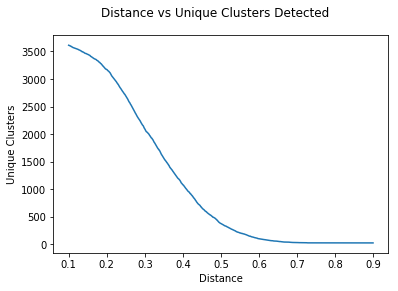

Max Clusters:3613 - Min Clusters:27


In [21]:
plt.plot(test_distances,unique_clusters)
plt.xlabel('Distance')
plt.ylabel('Unique Clusters')
plt.suptitle('Distance vs Unique Clusters Detected')
plt.show()
print("Max Clusters:{} - Min Clusters:{}".format(max(unique_clusters),min(unique_clusters)))


## Evaluating Results

In [22]:
import pandas as pd

## Vendor Results

In [117]:
results = pd.read_excel('Benetech_Deduping Report_25Jan2019.xlsx')

In [118]:
results.head()

Q ID  \
0  s3.videocitestest/7aa625db5d2943c4a031710c1c16...   
1  s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
2  s3.videocitestest/977daead5ed8427d80f876a55b17...   
3  s3.videocitestest/630485e8e04847a9b4976bf86796...   
4  s3.videocitestest/7875154237a2404dbd9caccb8cdc...   

                                               Q URL  Q Duration  Q Width  \
0  https://videocitestest.s3.amazonaws.com/7aa625...          16     1280   
1  https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
2  https://videocitestest.s3.amazonaws.com/977dae...          22     1088   
3  https://videocitestest.s3.amazonaws.com/630485...          29      459   
4  https://videocitestest.s3.amazonaws.com/787515...         106     1254   

   Q Height  Q FPS                                               M ID  \
0       720  25.00  s3.videocitestest/69Ri7ItDmS4-5717b7b1f2d8f77c...   
1       360  30.00  s3.videocitestest/6YmKwon4X0c-f518e04bd71707dd...   
2       612  25.00  s3.videocitestest/5O9mAuV217k-43007247e8a07168...   
3       306  29.97  s3.videocitestest/5f6aad4f3a954688bdc8f9471c41...   
4       705  29.97  s3.videocitestest/flsevUvm098-ba74e90711c9692f...   

                                               M URL  M Duration M Status  
0  https://videocitestest.s3.amazonaws.com/69Ri7I...          22    match  
1  https://videocitestest.s3.amazonaws.com/6YmKwo...         179    match  
2  https://videocitestest.s3.amazonaws.com/5O9mAu...          26    match  
3  https://videocitestest.s3.amazonaws.com/5f6aad...          31    match  
4  https://videocitestest.s3.amazonaws.com/flsevU...         112    match

In [119]:
results['q_filename'] = results['Q ID'].apply(lambda x:x.split('/')[-1])
results['m_filename'] = results['M ID'].apply(lambda x:x.split('/')[-1])

In [120]:
results.head()

Q ID  \
0  s3.videocitestest/7aa625db5d2943c4a031710c1c16...   
1  s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
2  s3.videocitestest/977daead5ed8427d80f876a55b17...   
3  s3.videocitestest/630485e8e04847a9b4976bf86796...   
4  s3.videocitestest/7875154237a2404dbd9caccb8cdc...   

                                               Q URL  Q Duration  Q Width  \
0  https://videocitestest.s3.amazonaws.com/7aa625...          16     1280   
1  https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
2  https://videocitestest.s3.amazonaws.com/977dae...          22     1088   
3  https://videocitestest.s3.amazonaws.com/630485...          29      459   
4  https://videocitestest.s3.amazonaws.com/787515...         106     1254   

   Q Height  Q FPS                                               M ID  \
0       720  25.00  s3.videocitestest/69Ri7ItDmS4-5717b7b1f2d8f77c...   
1       360  30.00  s3.videocitestest/6YmKwon4X0c-f518e04bd71707dd...   
2       612  25.00  s3.videocitestest/5O9mAuV217k-43007247e8a07168...   
3       306  29.97  s3.videocitestest/5f6aad4f3a954688bdc8f9471c41...   
4       705  29.97  s3.videocitestest/flsevUvm098-ba74e90711c9692f...   

                                               M URL  M Duration M Status  \
0  https://videocitestest.s3.amazonaws.com/69Ri7I...          22    match   
1  https://videocitestest.s3.amazonaws.com/6YmKwo...         179    match   
2  https://videocitestest.s3.amazonaws.com/5O9mAu...          26    match   
3  https://videocitestest.s3.amazonaws.com/5f6aad...          31    match   
4  https://videocitestest.s3.amazonaws.com/flsevU...         112    match   

                                         q_filename  \
0              7aa625db5d2943c4a031710c1c1686f7.mp4   
1  QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
2              977daead5ed8427d80f876a55b17496d.mp4   
3             630485e8e04847a9b4976bf867969576.webm   
4              7875154237a2404dbd9caccb8cdc3f28.mp4   

                                         m_filename  
0  69Ri7ItDmS4-5717b7b1f2d8f77c3a22532f2b1ce160.mp4  
1  6YmKwon4X0c-f518e04bd71707ddd985f89f03cc7784.mp4  
2  5O9mAuV217k-43007247e8a07168206c59b471770d3f.mp4  
3             5f6aad4f3a954688bdc8f9471c41da64.webm  
4  flsevUvm098-ba74e90711c9692f2a6a1157a6eaf146.mp4

In [121]:
unique_qs = results['q_filename'].value_counts().index

In [122]:
results.loc[results['q_filename'] == unique_qs[0],:]

Q ID  \
1    s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
71   s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
77   s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
163  s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
169  s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   
175  s3.videocitestest/QGFBGnpXMqE-07d9e6754f49d3eb...   

                                                 Q URL  Q Duration  Q Width  \
1    https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
71   https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
77   https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
163  https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
169  https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   
175  https://videocitestest.s3.amazonaws.com/QGFBGn...          81      640   

     Q Height  Q FPS                                               M ID  \
1         360   30.0  s3.videocitestest/6YmKwon4X0c-f518e04bd71707dd...   
71        360   30.0  s3.videocitestest/sW02MYKmUaM-f8c6ef6974e0d853...   
77        360   30.0  s3.videocitestest/018MsV21q00-3419176ec77eea4d...   
163       360   30.0  s3.videocitestest/4fbf84566d434628bc6954a36e77...   
169       360   30.0  s3.videocitestest/7faf034173f4451398b05e6f1686...   
175       360   30.0  s3.videocitestest/4214d032b0924870a216958e84a7...   

                                                 M URL  M Duration M Status  \
1    https://videocitestest.s3.amazonaws.com/6YmKwo...         179    match   
71   https://videocitestest.s3.amazonaws.com/sW02MY...          64    match   
77   https://videocitestest.s3.amazonaws.com/018MsV...          81    match   
163  https://videocitestest.s3.amazonaws.com/4fbf84...          79    match   
169  https://videocitestest.s3.amazonaws.com/7faf03...          83    match   
175  https://videocitestest.s3.amazonaws.com/4214d0...          86    match   

                                           q_filename  \
1    QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
71   QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
77   QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
163  QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
169  QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   
175  QGFBGnpXMqE-07d9e6754f49d3eb87d95767bff7e696.mp4   

                                           m_filename  
1    6YmKwon4X0c-f518e04bd71707ddd985f89f03cc7784.mp4  
71   sW02MYKmUaM-f8c6ef6974e0d853df113f45e1242628.mp4  
77   018MsV21q00-3419176ec77eea4da5161cf6faa05a3d.mp4  
163             4fbf84566d434628bc6954a36e7722d5.webm  
169             7faf034173f4451398b05e6f1686a896.webm  
175              4214d032b0924870a216958e84a7544a.ogv

In [123]:
augmentation_manifesto = pd.read_csv('/home/felipeb/augmenter/augmented_dataset_manifest')

In [124]:
augmentation_manifesto.head()

Unnamed: 0 banner bitrate  color_intensity         crop extension  \
0           0    NaN     32k             0.42          NaN       NaN   
1           1    NaN     64k             0.24          NaN       NaN   
2           2  False     NaN              NaN          NaN       NaN   
3           3    NaN     NaN              NaN  [0.11 0.15]       NaN   
4           4    NaN     NaN              NaN  [0.04 0.03]       NaN   

                                           file_path  intensity  \
0  /datadrive/videos/BVx0nR366sk-3b0933b1902d9a66...      -0.09   
1  /datadrive/videos/6Y1uTg7wCV8-b068dba553b7529e...      -0.05   
2  /datadrive/videos/VuW-M9TB7tM-73472a9187f950d4...      -0.12   
3  /datadrive/videos/gMz2bJykKaY-31b60bdf2a061902...        NaN   
4  /datadrive/videos/6QWIAsPOlxM-907ba6ac2932e487...      -0.19   

                logo  offset  shaky  shaky_after_logo  speed_change  \
0                NaN     NaN  False              True         -0.09   
1  logos/jazeera.png     6.0  False              True           NaN   
2      logos/fox.png     2.0  False             False           NaN   
3                NaN     3.0  False              True          0.34   
4      logos/sbt.gif     3.0  False             False          0.31   

                                       filename original_extension  \
0  BVx0nR366sk-3b0933b1902d9a66730d447258c425ec               webm   
1  6Y1uTg7wCV8-b068dba553b7529eb2c2c4727c47fed9               webm   
2  VuW-M9TB7tM-73472a9187f950d4812582d25154f1d4                mp4   
3  gMz2bJykKaY-31b60bdf2a061902a1c004eab2ced596               webm   
4  6QWIAsPOlxM-907ba6ac2932e487c215c9b364d06e14               webm   

                            new_filename  
0  16560611413745a1b33748cad5cdb726.webm  
1  4fe31156621142de9be93e3c6a4a8bd9.webm  
2   49f397b693eb41a9b7c8a95b0147c6a0.mp4  
3  e366f4367c2148c3bb4e88a6bf3b0835.webm  
4  7611fe4baab94392a82f5a8a28bdeba2.webm

In [125]:
import os

In [129]:
used.shape

(1594, 17)

In [130]:
augmentation_manifesto['original_basename'] = augmentation_manifesto['file_path'].apply(lambda x:os.path.basename(x))
test_dataset = [os.path.basename(x) for x in videos]
used = augmentation_manifesto.loc[augmentation_manifesto['new_filename'].isin(test_dataset),:]
used['isAugmented'] = True

In [131]:
used.shape

(1594, 18)

In [132]:
used.head()

Unnamed: 0 banner bitrate  color_intensity         crop extension  \
0           0    NaN     32k             0.42          NaN       NaN   
1           1    NaN     64k             0.24          NaN       NaN   
2           2  False     NaN              NaN          NaN       NaN   
4           4    NaN     NaN              NaN  [0.04 0.03]       NaN   
5           5   True     NaN              NaN          NaN       NaN   

                                           file_path  intensity  \
0  /datadrive/videos/BVx0nR366sk-3b0933b1902d9a66...      -0.09   
1  /datadrive/videos/6Y1uTg7wCV8-b068dba553b7529e...      -0.05   
2  /datadrive/videos/VuW-M9TB7tM-73472a9187f950d4...      -0.12   
4  /datadrive/videos/6QWIAsPOlxM-907ba6ac2932e487...      -0.19   
5  /datadrive/videos/gos1y5l9Pg0-d2f83335d3417005...      -0.20   

                logo  offset  shaky  shaky_after_logo  speed_change  \
0                NaN     NaN  False              True         -0.09   
1  logos/jazeera.png     6.0  False              True           NaN   
2      logos/fox.png     2.0  False             False           NaN   
4      logos/sbt.gif     3.0  False             False          0.31   
5                NaN     NaN  False             False          0.31   

                                       filename original_extension  \
0  BVx0nR366sk-3b0933b1902d9a66730d447258c425ec               webm   
1  6Y1uTg7wCV8-b068dba553b7529eb2c2c4727c47fed9               webm   
2  VuW-M9TB7tM-73472a9187f950d4812582d25154f1d4                mp4   
4  6QWIAsPOlxM-907ba6ac2932e487c215c9b364d06e14               webm   
5  gos1y5l9Pg0-d2f83335d34170054f7a1123314bc334                mp4   

                            new_filename  \
0  16560611413745a1b33748cad5cdb726.webm   
1  4fe31156621142de9be93e3c6a4a8bd9.webm   
2   49f397b693eb41a9b7c8a95b0147c6a0.mp4   
4  7611fe4baab94392a82f5a8a28bdeba2.webm   
5   b1fc155f185343d2a8ca8a5b9b240063.mp4   

                                   original_basename  isAugmented  
0  BVx0nR366sk-3b0933b1902d9a66730d447258c425ec.webm         True  
1  6Y1uTg7wCV8-b068dba553b7529eb2c2c4727c47fed9.webm         True  
2   VuW-M9TB7tM-73472a9187f950d4812582d25154f1d4.mp4         True  
4  6QWIAsPOlxM-907ba6ac2932e487c215c9b364d06e14.webm         True  
5   gos1y5l9Pg0-d2f83335d34170054f7a1123314bc334.mp4         True

In [145]:
augmented_files = used['new_filename'].values

In [1]:
vendor_df['augmented_q'] = False
vendor_df['augmented_m'] = False

vendor_df.loc[vendor_df['q_filename'].isin(augmented_files),'augmented_q'] = True
vendor_df.loc[vendor_df['m_filename'].isin(augmented_files),'augmented_m'] = True

NameError: name 'vendor_df' is not defined

In [149]:
results['augmented_q'].value_counts()

True     204
False     99
Name: augmented_q, dtype: int64

In [150]:
results['augmented_m'].value_counts()

True     166
False    137
Name: augmented_m, dtype: int64

Out of all the Matches that correspond to an original file, how many of them have an origin query that is an augmented file?

In [ ]:
results.loc[results['augmented_m'] == False,:]['augmented_q'].value_counts()

Out of all that matches that correspond to an augmented file, how many of them are originated by an augmented q?

In [ ]:
results.loc[results['augmented_m'] == True,:]['augmented_q'].value_counts()

In [33]:
detector_performance = []
for d in detectors:
    master_df = pd.DataFrame({'filename_no_ext':d.df['file_name'],'cluster_id':d.clusters})
    used['new_filename_no_ext'] = used['new_filename'].apply(lambda x:x.split('.')[0]) 
    merged = master_df.merge(used,how='outer',left_on='filename_no_ext',right_on='new_filename_no_ext')
    merged['isAugmented'] = merged['isAugmented'].fillna(False)
    merged['transp_fn'] = merged['original_basename'].fillna(merged['filename_no_ext'])
    merged['transp_fn'] = merged['transp_fn'].apply(lambda x:x.split('.')[0])
    versions_per_file = merged.transp_fn.value_counts() 
    files_of_interest = versions_per_file[versions_per_file > 1].index
    noise_cluster = merged.cluster_id.value_counts().index[0]
    results = []
    for x in files_of_interest:
        f = merged.loc[merged.transp_fn == x,['cluster_id','transp_fn']]
        m = f['cluster_id'].value_counts().values[0]
        p = m / f.shape[0]
        if f['cluster_id'].value_counts().index[0] == noise_cluster:
#             print('noise detected')
            p = 0
    
        results.append(p)
    r = np.mean(results)
    print(r)
    detector_performance.append(r)

0.48841607565011824
0.48826832151300237
0.48967198581560284
0.4908540189125295
0.4908540189125295
0.48952423167848697
0.491297281323877
0.49203605200945627
0.49203605200945627
0.4929225768321513
0.49277482269503536
0.49395685579196225
0.493291962174941
0.4937352245862885
0.49454787234042547
0.49590721040189123
0.49575945626477547
0.496202718676123
0.496202718676123
0.4983156028368795
0.49816784869976355
0.49861111111111117
0.4992316784869976
0.5007387706855791
0.5014775413711584
0.5019208037825059
0.5022901891252954
0.5018026004728132
0.5030585106382979
0.5024674940898345
0.502910756501182
0.5043882978723405
0.5060874704491726
0.5062352245862883
0.505821513002364
0.505821513002364
0.5072990543735225
0.5084072104018913
0.5109190307328605
0.5106973995271867
0.512322695035461
0.5127659574468085
0.5117612293144208
0.5132387706855791
0.5147458628841608
0.5147458628841608
0.514450354609929
0.514450354609929
0.5156323877068558
0.5176270685579196
0.5169621749408984
0.5195478723404255
0.5199911

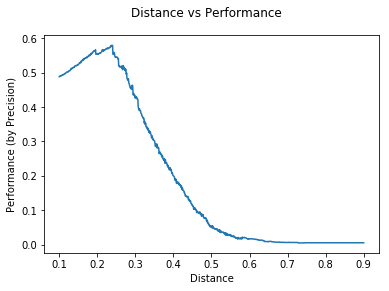

Best Performance:0.579861111111111 - at distance:0.23853853853853854


In [34]:
plt.plot(test_distances,detector_performance)
plt.xlabel('Distance')
plt.ylabel('Performance (by Precision)')
plt.suptitle('Distance vs Performance')
plt.show()
# print("Max Clusters:{} - Min Clusters:{}".format(max(unique_clusters),min(unique_clusters)))
print('Best Performance:{} - at distance:{}'.format(np.max(detector_performance),test_distances[np.argmax(detector_performance)]))

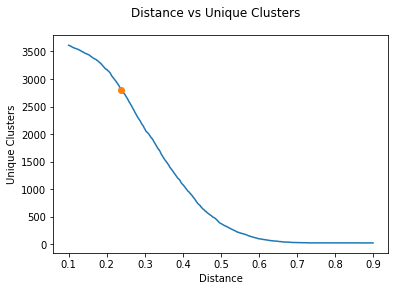

In [35]:
plt.plot(test_distances,unique_clusters)
plt.plot(test_distances[np.argmax(detector_performance)],unique_clusters[np.argmax(detector_performance)],marker='o')
plt.xlabel('Distance')
plt.ylabel('Unique Clusters')
plt.suptitle('Distance vs Unique Clusters')
plt.show()

## Evaluating only on Augmented Samples that have 

## Proposed Metric

For each file of interest:

    1. Filter all Augmented Versions
    2. % / Augmented Versions of prevailing Cluster id 
    3. Aggregated Metric 


In [36]:
noise_cluster = merged.cluster_id.value_counts().index[0]
noise_cluster

0

In [37]:
merged.isnull().sum()

filename_no_ext           0
cluster_id                0
Unnamed: 0             2249
banner                 3060
bitrate                3062
color_intensity        3059
crop                   3113
extension              3040
file_path              2249
intensity              3063
logo                   3056
offset                 3049
shaky                  2249
shaky_after_logo       2249
speed_change           3028
filename               2249
original_extension     2249
new_filename           2249
original_basename      2249
isAugmented               0
new_filename_no_ext    2249
transp_fn                 0
dtype: int64

In [38]:
precise = detectors[-2]

In [39]:
precise.attach_source_videos(VIDEOS_LIST)

/home/felipeb/winnow/notebooks/syria_videos.txt


In [40]:
precise.df.cluster.value_counts()

0     3817
24       1
2        1
4        1
6        1
8        1
10       1
12       1
14       1
16       1
18       1
20       1
22       1
25       1
23       1
1        1
3        1
5        1
7        1
9        1
11       1
13       1
15       1
17       1
19       1
21       1
26       1
Name: cluster, dtype: int64

In [41]:
test_distances = [0.00001,0.0001,0.001,0.01,0.1,0.2,0.3,0.4]

In [42]:
for i,d in enumerate(test_distances):
    precise.df['cluster_at_{}'.format(i)] = detectors[i].df['cluster']

In [43]:
clusters_of_interest = [69, 373, 368, 114, 22]

In [44]:
precise.df[precise.df['cluster_at_4'] == 69]

signature_fp  cluster  \
70  /datadrive/intermediate/video_level/cb38060be9...        0   

                           file_name  \
70  cb38060be99c4651a68dfb7080b24de6   

                                                   fp  cluster_at_0  \
70  /datadrive/test_dataset/cb38060be99c4651a68dfb...            69   

    cluster_at_1  cluster_at_2  cluster_at_3  cluster_at_4  cluster_at_5  \
70            69            69            69            69            69   

    cluster_at_6  cluster_at_7  
70            69            69

In [45]:
precise.df[precise.df['cluster_at_4'] == 373]

signature_fp  cluster  \
381  /datadrive/intermediate/video_level/1196087e4e...        0   

                            file_name  \
381  1196087e4ef7400980b5b88122a14687   

                                                    fp  cluster_at_0  \
381  /datadrive/test_dataset/1196087e4ef7400980b5b8...           374   

     cluster_at_1  cluster_at_2  cluster_at_3  cluster_at_4  cluster_at_5  \
381           373           373           373           373           373   

     cluster_at_6  cluster_at_7  
381           373           373

In [46]:
precise.df[precise.df['cluster_at_4'] == 368]

signature_fp  cluster  \
376  /datadrive/intermediate/video_level/b77634156b...        0   

                            file_name  \
376  b77634156b1d47bcb7ff6d2f2278590b   

                                                    fp  cluster_at_0  \
376  /datadrive/test_dataset/b77634156b1d47bcb7ff6d...           369   

     cluster_at_1  cluster_at_2  cluster_at_3  cluster_at_4  cluster_at_5  \
376           368           368           368           368           368   

     cluster_at_6  cluster_at_7  
376           368           368

In [47]:
precise.df[precise.df['cluster_at_4'] == 114]

signature_fp  cluster  \
115  /datadrive/intermediate/video_level/d3bf2dff89...        0   

                            file_name  \
115  d3bf2dff89e341db974e1bbee36d4597   

                                                    fp  cluster_at_0  \
115  /datadrive/test_dataset/d3bf2dff89e341db974e1b...           114   

     cluster_at_1  cluster_at_2  cluster_at_3  cluster_at_4  cluster_at_5  \
115           114           114           114           114           114   

     cluster_at_6  cluster_at_7  
115           114           114

In [48]:
precise.df[precise.df['cluster_at_4'] == 22]

signature_fp  cluster  \
22  /datadrive/intermediate/video_level/8bWrjGdeO7...        0   

                                       file_name  \
22  8bWrjGdeO7s-e94398b4c162a7497030a49a29904a48   

                                                   fp  cluster_at_0  \
22  /datadrive/test_dataset/8bWrjGdeO7s-e94398b4c1...            22   

    cluster_at_1  cluster_at_2  cluster_at_3  cluster_at_4  cluster_at_5  \
22            22            22            22            22            22   

    cluster_at_6  cluster_at_7  
22            22            22

In [49]:
precise.df.to_csv('cluster_results.csv')

In [50]:
detector_2 = DuplicateDetector(distance=0.01,signatures = sm.index)
detector_3 = DuplicateDetector(distance=0.001,signatures = sm.index)
detector_4 = DuplicateDetector(distance=0.0001,signatures = sm.index)
detector_5 = DuplicateDetector(distance=0.00001,signatures = sm.index)
detector_6 = DuplicateDetector(distance=0.2,signatures = sm.index)
detector_7 = DuplicateDetector(distance=0.3,signatures = sm.index)

White Square should show concentrations of duplicated documents


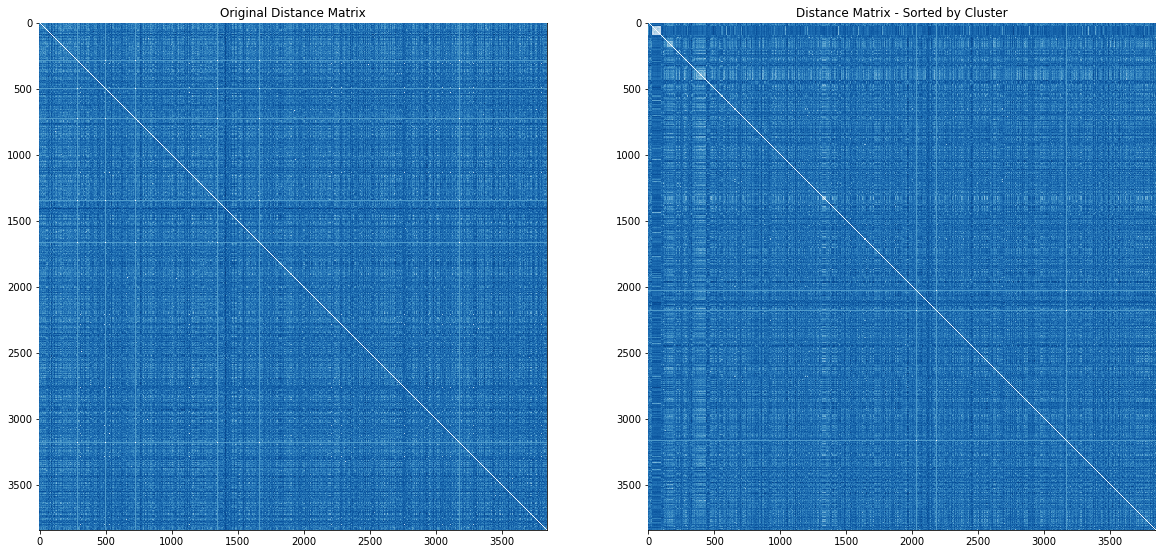

In [51]:
# Sorted vs Unsorted Matrix
detector.show_distance_matrix(comparison=True)

In [53]:
detector_3.show_distance_matrix(comparison=True)

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [11]:
# Attach source video references 
detector.attach_source_videos(VIDEOS_LIST)

/home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/notebooks/syria_videos.txt


In [12]:
VIDEOS_LIST

'/home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/notebooks/syria_videos.txt'

In [13]:
# Show samples from duplicated files
detector.show_samples(indexToFilePath)

AttributeError: 'DuplicateDetector' object has no attribute 'show_samples'

In [13]:
detector.summary()

69     3
311    2
75     2
107    2
398    2
540    2
242    2
99     2
95     2
89     2
86     2
256    2
74     2
46     2
373    2
368    2
367    2
64     2
268    2
360    2
359    2
355    2
111    2
232    2
114    2
406    2
464    2
458    2
177    2
453    2
      ..
415    1
413    1
443    1
412    1
411    1
410    1
409    1
408    1
407    1
405    1
422    1
424    1
425    1
426    1
442    1
441    1
440    1
439    1
438    1
437    1
435    1
434    1
433    1
432    1
431    1
430    1
429    1
428    1
427    1
0      1
Name: cluster, Length: 646, dtype: int64

## HDBSCAN

In [6]:
import hdbscan

In [64]:
distances = [x for x in hdbscan.dist_metrics.METRIC_MAPPING if x not in ['infinity','minkowski','chebyshev','l1']]

In [65]:
distances

['euclidean',
 'l2',
 'p',
 'manhattan',
 'cityblock',
 'seuclidean',
 'mahalanobis',
 'wminkowski',
 'hamming',
 'canberra',
 'braycurtis',
 'matching',
 'jaccard',
 'dice',
 'kulsinski',
 'rogerstanimoto',
 'russellrao',
 'sokalmichener',
 'sokalsneath',
 'haversine',
 'cosine',
 'arccos',
 'pyfunc']

In [76]:
clusterer = hdbscan.RobustSingleLinkage(cut=0.1)
clusterer.fit(video_signatures)

print(clusterer.labels_.max())
print(Counter(clusterer.labels_).most_common(1))

ValueError: Buffer dtype mismatch, expected 'double_t' but got 'float'

In [63]:
for d in distances:
    clusterer = hdbscan.HDBSCAN(metric=d,min_samples=1,min_cluster_size=2,allow_single_cluster=True)
    clusterer.fit(video_signatures)
    print(d)
    print(clusterer.labels_.max())
# Counter(clusterer.labels_).most_common()

euclidean
127
l2
127
p
127
manhattan
130
cityblock
130


TypeError: __init__() takes exactly 1 positional argument (0 given)

HDBSCAN(algorithm='best', allow_single_cluster=True, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=2, min_samples=1, p=None,
    prediction_data=False)

In [34]:
from collections import Counter

In [37]:
clusterer.labels_.max()

127

[(-1, 376),
 (124, 11),
 (110, 10),
 (46, 7),
 (104, 5),
 (109, 4),
 (64, 4),
 (89, 4),
 (125, 4),
 (99, 4),
 (116, 4),
 (73, 4),
 (27, 4),
 (53, 4),
 (107, 4),
 (83, 3),
 (7, 3),
 (82, 3),
 (2, 3),
 (39, 3),
 (41, 3),
 (84, 3),
 (10, 3),
 (61, 3),
 (59, 3),
 (30, 3),
 (18, 3),
 (56, 3),
 (48, 3),
 (95, 3),
 (13, 3),
 (9, 3),
 (17, 3),
 (24, 3),
 (106, 3),
 (87, 3),
 (60, 3),
 (29, 3),
 (121, 3),
 (34, 3),
 (58, 3),
 (35, 3),
 (93, 3),
 (40, 3),
 (90, 3),
 (88, 3),
 (54, 2),
 (96, 2),
 (16, 2),
 (1, 2),
 (74, 2),
 (97, 2),
 (105, 2),
 (49, 2),
 (112, 2),
 (103, 2),
 (126, 2),
 (91, 2),
 (26, 2),
 (70, 2),
 (3, 2),
 (4, 2),
 (79, 2),
 (76, 2),
 (12, 2),
 (111, 2),
 (55, 2),
 (0, 2),
 (14, 2),
 (15, 2),
 (5, 2),
 (63, 2),
 (8, 2),
 (102, 2),
 (68, 2),
 (42, 2),
 (67, 2),
 (38, 2),
 (52, 2),
 (57, 2),
 (77, 2),
 (47, 2),
 (115, 2),
 (114, 2),
 (51, 2),
 (86, 2),
 (23, 2),
 (20, 2),
 (92, 2),
 (69, 2),
 (50, 2),
 (31, 2),
 (28, 2),
 (65, 2),
 (45, 2),
 (117, 2),
 (127, 2),
 (66, 2),
 (33, 

In [15]:
clusters_of_interest = detector.summary()[detector.summary() > 1].index.values

In [ ]:
for c in clusters_of_interest:
    print('CLUSTER',c)
    try:
        s = detector.show_cluster(c)
        plt.figure(figsize=(20,20))
        plt.imshow(np.vstack(s))
        plt.show()
    except as e:
        print('cluster failed',c)

 19%|█▉        | 111/580 [00:00<00:00, 1108.76frames/s]

CLUSTER 69


 10%|▉         | 46/481 [00:00<00:00, 457.24frames/s]

[(FrameTimecode(frame=20, fps=29.970030), FrameTimecode(frame=254, fps=29.970030)), (FrameTimecode(frame=254, fps=29.970030), FrameTimecode(frame=580, fps=29.970030))]


  9%|▉         | 44/481 [00:00<00:00, 439.57frames/s]

[]


100%|██████████| 481/481 [00:01<00:00, 439.81frames/s]


[]


  7%|▋         | 41/581 [00:00<00:01, 404.93frames/s]

cluster failed 69
CLUSTER 311


  9%|▉         | 44/481 [00:00<00:00, 438.33frames/s]

[(FrameTimecode(frame=20, fps=30.000000), FrameTimecode(frame=112, fps=30.000000)), (FrameTimecode(frame=112, fps=30.000000), FrameTimecode(frame=239, fps=30.000000)), (FrameTimecode(frame=239, fps=30.000000), FrameTimecode(frame=264, fps=30.000000)), (FrameTimecode(frame=264, fps=30.000000), FrameTimecode(frame=325, fps=30.000000)), (FrameTimecode(frame=325, fps=30.000000), FrameTimecode(frame=341, fps=30.000000)), (FrameTimecode(frame=341, fps=30.000000), FrameTimecode(frame=388, fps=30.000000)), (FrameTimecode(frame=388, fps=30.000000), FrameTimecode(frame=516, fps=30.000000)), (FrameTimecode(frame=516, fps=30.000000), FrameTimecode(frame=581, fps=30.000000))]


100%|██████████| 481/481 [00:01<00:00, 456.76frames/s]


[(FrameTimecode(frame=20, fps=25.000000), FrameTimecode(frame=93, fps=25.000000)), (FrameTimecode(frame=93, fps=25.000000), FrameTimecode(frame=199, fps=25.000000)), (FrameTimecode(frame=199, fps=25.000000), FrameTimecode(frame=220, fps=25.000000)), (FrameTimecode(frame=220, fps=25.000000), FrameTimecode(frame=271, fps=25.000000)), (FrameTimecode(frame=271, fps=25.000000), FrameTimecode(frame=287, fps=25.000000)), (FrameTimecode(frame=287, fps=25.000000), FrameTimecode(frame=323, fps=25.000000)), (FrameTimecode(frame=323, fps=25.000000), FrameTimecode(frame=430, fps=25.000000)), (FrameTimecode(frame=430, fps=25.000000), FrameTimecode(frame=481, fps=25.000000))]


  0%|          | 0/100 [00:00<?, ?frames/s]

cluster failed 311
CLUSTER 75
[]


  0%|          | 0/481 [00:00<?, ?frames/s]

[]
cluster failed 75
CLUSTER 107


  7%|▋         | 42/581 [00:00<00:01, 419.98frames/s]

[]


100%|██████████| 581/581 [00:01<00:00, 458.36frames/s]


[]


 10%|▉         | 46/481 [00:00<00:00, 457.69frames/s]

cluster failed 107
CLUSTER 398


  9%|▉         | 44/481 [00:00<00:00, 439.03frames/s]

[(FrameTimecode(frame=20, fps=25.000000), FrameTimecode(frame=271, fps=25.000000)), (FrameTimecode(frame=271, fps=25.000000), FrameTimecode(frame=481, fps=25.000000))]


100%|██████████| 481/481 [00:01<00:00, 462.34frames/s]


[(FrameTimecode(frame=20, fps=25.000000), FrameTimecode(frame=271, fps=25.000000)), (FrameTimecode(frame=271, fps=25.000000), FrameTimecode(frame=481, fps=25.000000))]


  7%|▋         | 42/581 [00:00<00:01, 412.29frames/s]

cluster failed 398
CLUSTER 540


  7%|▋         | 42/581 [00:00<00:01, 414.91frames/s]

[(FrameTimecode(frame=20, fps=30.000000), FrameTimecode(frame=54, fps=30.000000)), (FrameTimecode(frame=54, fps=30.000000), FrameTimecode(frame=89, fps=30.000000)), (FrameTimecode(frame=89, fps=30.000000), FrameTimecode(frame=151, fps=30.000000)), (FrameTimecode(frame=151, fps=30.000000), FrameTimecode(frame=176, fps=30.000000)), (FrameTimecode(frame=176, fps=30.000000), FrameTimecode(frame=212, fps=30.000000)), (FrameTimecode(frame=212, fps=30.000000), FrameTimecode(frame=237, fps=30.000000)), (FrameTimecode(frame=237, fps=30.000000), FrameTimecode(frame=363, fps=30.000000)), (FrameTimecode(frame=363, fps=30.000000), FrameTimecode(frame=582, fps=30.000000)), (FrameTimecode(frame=582, fps=30.000000), FrameTimecode(frame=581, fps=30.000000))]


100%|██████████| 581/581 [00:01<00:00, 428.92frames/s]


[(FrameTimecode(frame=20, fps=30.000000), FrameTimecode(frame=54, fps=30.000000)), (FrameTimecode(frame=54, fps=30.000000), FrameTimecode(frame=89, fps=30.000000)), (FrameTimecode(frame=89, fps=30.000000), FrameTimecode(frame=151, fps=30.000000)), (FrameTimecode(frame=151, fps=30.000000), FrameTimecode(frame=176, fps=30.000000)), (FrameTimecode(frame=176, fps=30.000000), FrameTimecode(frame=212, fps=30.000000)), (FrameTimecode(frame=212, fps=30.000000), FrameTimecode(frame=237, fps=30.000000)), (FrameTimecode(frame=237, fps=30.000000), FrameTimecode(frame=363, fps=30.000000)), (FrameTimecode(frame=363, fps=30.000000), FrameTimecode(frame=582, fps=30.000000)), (FrameTimecode(frame=582, fps=30.000000), FrameTimecode(frame=581, fps=30.000000))]


  7%|▋         | 43/581 [00:00<00:01, 422.92frames/s]

cluster failed 540
CLUSTER 242


  8%|▊         | 44/581 [00:00<00:01, 437.94frames/s]

[]


100%|██████████| 581/581 [00:01<00:00, 445.55frames/s]


[]


  9%|▉         | 43/481 [00:00<00:01, 429.52frames/s]

cluster failed 242
CLUSTER 99


 73%|███████▎  | 353/481 [00:00<00:00, 437.68frames/s]

In [ ]:
s = detector.show_cluster(69)

In [18]:
import matplotlib.pyplot as plt

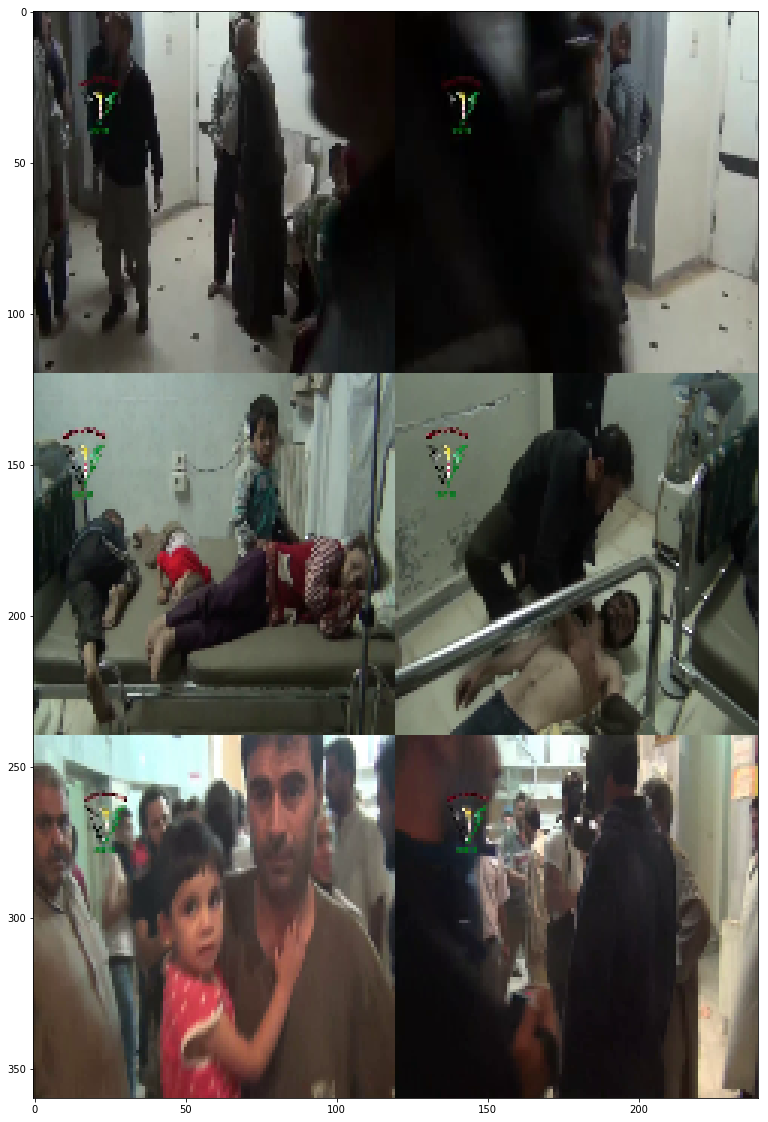

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(np.vstack(s))

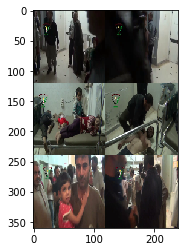

In [15]:
%debug

> /home/felipe/anaconda3/lib/python3.6/site-packages/numpy/core/shape_base.py(288)hstack()
    286         return _nx.concatenate(arrs, 0)
    287     else:
--> 288         return _nx.concatenate(arrs, 1)
    289 
    290 



ipdb>  up


> /home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/winnow/duplicate_detection/scene_summary.py(77)get_video_summary_list()
     75         clip = VideoFileClip(vid)
     76         frames = [Image.fromarray(f).resize((120,120)) for i,f in enumerate(clip.iter_frames()) if i in frame_list]
---> 77         summaries.append(np.hstack(frames))
     78 
     79     return summaries



ipdb>  frames


[]


ipdb>  frame_list


[]


ipdb>  scene_descriptors


*** NameError: name 'scene_descriptors' is not defined


ipdb>  scenes_descriptors


[[], [], [(FrameTimecode(frame=20, fps=29.970030), FrameTimecode(frame=254, fps=29.970030)), (FrameTimecode(frame=254, fps=29.970030), FrameTimecode(frame=580, fps=29.970030))]]


ipdb>  exit()


In [17]:
SYRIA_VIDEOS = np.array(glob(os.path.abspath('../data/external/SYRIA_VIDEOS/**')))
len(SYRIA_VIDEOS)
np.savetxt('syria_videos.txt',SYRIA_VIDEOS,fmt='%s')

In [18]:
import pandas as pd

In [19]:
results_df = pd.DataFrame({'signature_fp':sm.index,'cluster':clustes})

In [20]:
syria_list = pd.read_csv('syria_videos.txt',header=None,names=['fp'])
syria_list.head()

fp
0  /home/felipe/ai/toptal/benetech/WinnowProject ...
1  /home/felipe/ai/toptal/benetech/WinnowProject ...
2  /home/felipe/ai/toptal/benetech/WinnowProject ...
3  /home/felipe/ai/toptal/benetech/WinnowProject ...
4  /home/felipe/ai/toptal/benetech/WinnowProject ...

In [21]:
syria_list['file_name'] = syria_list['fp'].apply(lambda x:x.split('/')[-1].split('.')[0])

In [22]:
syria_list.head()

fp    file_name
0  /home/felipe/ai/toptal/benetech/WinnowProject ...  TJjz-u29kFI
1  /home/felipe/ai/toptal/benetech/WinnowProject ...  km0hDl-1Y2w
2  /home/felipe/ai/toptal/benetech/WinnowProject ...  96z1ePXyzqM
3  /home/felipe/ai/toptal/benetech/WinnowProject ...  gbtg8WrbRvI
4  /home/felipe/ai/toptal/benetech/WinnowProject ...  7fkluR69wUg

In [23]:
results_df.head()

signature_fp  cluster
0  ../data/processed/syria_videos/video_level/hQf...        0
1  ../data/processed/syria_videos/video_level/2DC...        1
2  ../data/processed/syria_videos/video_level/Y6I...        2
3  ../data/processed/syria_videos/video_level/zEu...        3
4  ../data/processed/syria_videos/video_level/IAX...        4

In [48]:
results_df['file_name'] = results_df['signature_fp'].apply(lambda x:x.split('/')[-1].split('.')[0].split('_vgg')[0])

In [49]:
results_df.head()

signature_fp  cluster    file_name
0  ../data/processed/syria_videos/video_level/hQf...        0  hQfT_UIYYB4
1  ../data/processed/syria_videos/video_level/2DC...        1  2DCpxpgvKjE
2  ../data/processed/syria_videos/video_level/Y6I...        2  Y6IfWwr4ZOU
3  ../data/processed/syria_videos/video_level/zEu...        3  zEutXW563Hk
4  ../data/processed/syria_videos/video_level/IAX...        4  IAXHMJLxZ_I

In [50]:
merged = results_df.merge(syria_list,on='file_name')

In [53]:
merged.head()

signature_fp  cluster    file_name  \
0  ../data/processed/syria_videos/video_level/hQf...        0  hQfT_UIYYB4   
1  ../data/processed/syria_videos/video_level/2DC...        1  2DCpxpgvKjE   
2  ../data/processed/syria_videos/video_level/Y6I...        2  Y6IfWwr4ZOU   
3  ../data/processed/syria_videos/video_level/zEu...        3  zEutXW563Hk   
4  ../data/processed/syria_videos/video_level/IAX...        4  IAXHMJLxZ_I   

                                                  fp  
0  /home/felipe/ai/toptal/benetech/WinnowProject ...  
1  /home/felipe/ai/toptal/benetech/WinnowProject ...  
2  /home/felipe/ai/toptal/benetech/WinnowProject ...  
3  /home/felipe/ai/toptal/benetech/WinnowProject ...  
4  /home/felipe/ai/toptal/benetech/WinnowProject ...

In [51]:
merged.shape

(709, 4)

In [67]:
per_cluster = merged['cluster'].value_counts() 
clusters_of_interest = per_cluster[per_cluster > 1].index.values

In [80]:
for c in clusters_of_interest[9:]:
    sample_videos = merged.loc[merged['cluster'] == c]['fp'].values
    clip1 = VideoFileClip(sample_videos[0]).margin(10) # add 10px contour
    clip2 = VideoFileClip(sample_videos[1])
    final_clip = clips_array([[clip1, clip2]])
    final_clip.resize(width=480).write_videofile("cluster_{}.mp4".format(c))
    
    
    

[MoviePy] >>>> Building video cluster_89.mp4
[MoviePy] Writing audio in cluster_89TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3823 [00:00<?, ?it/s]

  4%|▍         | 152/3823 [00:00<00:02, 1462.77it/s]

  8%|▊         | 305/3823 [00:00<00:02, 1477.79it/s]

 13%|█▎        | 507/3823 [00:00<00:02, 1607.05it/s]

 18%|█▊        | 701/3823 [00:00<00:01, 1694.10it/s]

 22%|██▏       | 859/3823 [00:00<00:01, 1657.07it/s]

 27%|██▋       | 1029/3823 [00:00<00:01, 1668.31it/s]

 32%|███▏      | 1213/3823 [00:00<00:01, 1715.58it/s]

 36%|███▌      | 1375/3823 [00:00<00:01, 1650.13it/s]

 40%|████      | 1544/3823 [00:00<00:01, 1661.48it/s]

 45%|████▍     | 1714/3823 [00:01<00:01, 1672.03it/s]

 49%|████▉     | 1878/3823 [00:01<00:01, 1614.96it/s]

 54%|█████▍    | 2071/3823 [00:01<00:01, 1697.82it/s]

 59%|█████▊    | 2241/3823 [00:01<00:00, 1667.09it/s]

 64%|██████▎   | 2432/3823 [00:01<00:00, 1732.97it/s]

 68%|██████▊   | 2606/3823 [00:01<00:00, 1718.57it/s]

 73%|███████▎  | 2804/3823 [00:01<00:00, 1775.25it/s]

 78%|███████▊  | 2988/3823 [00:01<00:00, 1791.87it/s]

 83%|████████▎ | 3168/3823

[MoviePy] Done.
[MoviePy] Writing video cluster_89.mp4




  0%|          | 0/4335 [00:00<?, ?it/s]

  0%|          | 2/4335 [00:00<04:34, 15.77it/s]

  0%|          | 4/4335 [00:00<04:30, 15.99it/s]

  0%|          | 6/4335 [00:00<04:28, 16.14it/s]

  0%|          | 8/4335 [00:00<04:27, 16.20it/s]

  0%|          | 10/4335 [00:00<04:21, 16.52it/s]

  0%|          | 12/4335 [00:00<04:22, 16.47it/s]

  0%|          | 14/4335 [00:00<04:20, 16.57it/s]

  0%|          | 16/4335 [00:00<04:19, 16.66it/s]

  0%|          | 18/4335 [00:01<04:20, 16.60it/s]

  0%|          | 20/4335 [00:01<04:23, 16.39it/s]

  1%|          | 22/4335 [00:01<04:23, 16.34it/s]

  1%|          | 24/4335 [00:01<04:26, 16.16it/s]

  1%|          | 26/4335 [00:01<04:30, 15.94it/s]

  1%|          | 28/4335 [00:01<04:31, 15.88it/s]

  1%|          | 30/4335 [00:01<04:30, 15.94it/s]

  1%|          | 32/4335 [00:01<04:25, 16.19it/s]

  1%|          | 34/4335 [00:02<04:31, 15.85it/s]

  1%|          | 36/4335 [00:02<04:33, 15.72it/s]

  1%|          | 38/4335 [00:02<04:33, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_89.mp4 

[MoviePy] >>>> Building video cluster_86.mp4
[MoviePy] Writing audio in cluster_86TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1436 [00:00<?, ?it/s]

 11%|█         | 161/1436 [00:00<00:00, 1605.83it/s]

 25%|██▍       | 356/1436 [00:00<00:00, 1678.31it/s]

 39%|███▉      | 560/1436 [00:00<00:00, 1764.72it/s]

 52%|█████▏    | 752/1436 [00:00<00:00, 1807.45it/s]

 66%|██████▌   | 947/1436 [00:00<00:00, 1846.07it/s]

 80%|████████  | 1149/1436 [00:00<00:00, 1892.36it/s]

 92%|█████████▏| 1321/1436 [00:00<00:00, 1786.86it/s]

100%|██████████| 1436/1436 [00:00<00:00, 1807.63it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_86.mp4




  0%|          | 0/1954 [00:00<?, ?it/s]

  0%|          | 7/1954 [00:00<00:28, 67.46it/s]

  1%|          | 14/1954 [00:00<00:28, 67.65it/s]

  1%|          | 22/1954 [00:00<00:27, 69.36it/s]

  2%|▏         | 30/1954 [00:00<00:27, 70.28it/s]

  2%|▏         | 38/1954 [00:00<00:26, 71.45it/s]

  2%|▏         | 46/1954 [00:00<00:26, 71.98it/s]

  3%|▎         | 54/1954 [00:00<00:26, 71.70it/s]

  3%|▎         | 61/1954 [00:00<00:27, 69.25it/s]

  4%|▎         | 69/1954 [00:00<00:26, 70.14it/s]

  4%|▍         | 76/1954 [00:01<00:27, 67.71it/s]

  4%|▍         | 83/1954 [00:01<00:27, 67.06it/s]

  5%|▍         | 90/1954 [00:01<00:27, 67.84it/s]

  5%|▍         | 97/1954 [00:01<00:27, 67.86it/s]

  5%|▌         | 105/1954 [00:01<00:26, 68.96it/s]

  6%|▌         | 112/1954 [00:01<00:26, 68.38it/s]

  6%|▌         | 119/1954 [00:01<00:27, 67.61it/s]

  6%|▋         | 126/1954 [00:01<00:27, 66.85it/s]

  7%|▋         | 133/1954 [00:01<00:27, 66.84it/s]

  7%|▋         | 140/1954 [00:02<0

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_86.mp4 

[MoviePy] >>>> Building video cluster_256.mp4
[MoviePy] Writing audio in cluster_256TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3178 [00:00<?, ?it/s]

  4%|▎         | 114/3178 [00:00<00:02, 1138.33it/s]

  8%|▊         | 254/3178 [00:00<00:02, 1191.04it/s]

 12%|█▏        | 397/3178 [00:00<00:02, 1253.26it/s]

 17%|█▋        | 540/3178 [00:00<00:02, 1300.96it/s]

 21%|██▏       | 682/3178 [00:00<00:01, 1332.72it/s]

 26%|██▌       | 828/3178 [00:00<00:01, 1367.94it/s]

 31%|███       | 981/3178 [00:00<00:01, 1410.79it/s]

 35%|███▌      | 1121/3178 [00:00<00:01, 1386.82it/s]

 40%|███▉      | 1269/3178 [00:00<00:01, 1413.15it/s]

 45%|████▍     | 1419/3178 [00:01<00:01, 1434.74it/s]

 49%|████▉     | 1560/3178 [00:01<00:01, 1352.22it/s]

 55%|█████▍    | 1733/3178 [00:01<00:00, 1445.26it/s]

 65%|██████▌   | 2072/3178 [00:01<00:00, 1745.39it/s]

 75%|███████▍  | 2371/3178 [00:01<00:00, 1993.71it/s]

 84%|████████▍ | 2681/3178 [00:01<00:00, 2232.08it/s]

 95%|█████████▍| 3010/3178 [00:01<00:00, 2470.38it/s]

100%|██████████| 3178/3178 [00:01<00:00, 1882.55it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_256.mp4




  0%|          | 0/3603 [00:00<?, ?it/s]

  0%|          | 2/3603 [00:00<03:43, 16.08it/s]

  0%|          | 4/3603 [00:00<03:43, 16.08it/s]

  0%|          | 6/3603 [00:00<03:43, 16.08it/s]

  0%|          | 8/3603 [00:00<03:48, 15.76it/s]

  0%|          | 10/3603 [00:00<03:46, 15.88it/s]

  0%|          | 12/3603 [00:00<03:44, 16.01it/s]

  0%|          | 14/3603 [00:00<03:44, 15.97it/s]

  0%|          | 16/3603 [00:01<03:43, 16.08it/s]

  0%|          | 18/3603 [00:01<03:44, 15.94it/s]

  1%|          | 20/3603 [00:01<03:43, 16.03it/s]

  1%|          | 22/3603 [00:01<03:47, 15.75it/s]

  1%|          | 24/3603 [00:01<03:43, 15.98it/s]

  1%|          | 26/3603 [00:01<03:41, 16.16it/s]

  1%|          | 28/3603 [00:01<03:40, 16.20it/s]

  1%|          | 30/3603 [00:01<03:41, 16.15it/s]

  1%|          | 32/3603 [00:01<03:39, 16.25it/s]

  1%|          | 34/3603 [00:02<03:46, 15.79it/s]

  1%|          | 36/3603 [00:02<03:45, 15.81it/s]

  1%|          | 38/3603 [00:02<03:45, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_256.mp4 

[MoviePy] >>>> Building video cluster_74.mp4
[MoviePy] Writing audio in cluster_74TEMP_MPY_wvf_snd.mp3




  0%|          | 0/656 [00:00<?, ?it/s]

 20%|██        | 133/656 [00:00<00:00, 1329.77it/s]

 44%|████▍     | 287/656 [00:00<00:00, 1385.47it/s]

 68%|██████▊   | 446/656 [00:00<00:00, 1440.89it/s]

 91%|█████████ | 598/656 [00:00<00:00, 1459.45it/s]

100%|██████████| 656/656 [00:00<00:00, 1487.41it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_74.mp4




  0%|          | 0/892 [00:00<?, ?it/s]

  0%|          | 2/892 [00:00<00:56, 15.67it/s]

  0%|          | 4/892 [00:00<00:56, 15.79it/s]

  1%|          | 6/892 [00:00<00:55, 15.92it/s]

  1%|          | 8/892 [00:00<00:55, 16.03it/s]

  1%|          | 10/892 [00:00<00:55, 15.83it/s]

  1%|▏         | 12/892 [00:00<00:55, 15.75it/s]

  2%|▏         | 14/892 [00:00<00:56, 15.44it/s]

  2%|▏         | 16/892 [00:01<00:55, 15.69it/s]

  2%|▏         | 18/892 [00:01<00:55, 15.69it/s]

  2%|▏         | 20/892 [00:01<00:55, 15.85it/s]

  2%|▏         | 22/892 [00:01<00:54, 15.96it/s]

  3%|▎         | 24/892 [00:01<00:56, 15.47it/s]

  3%|▎         | 26/892 [00:01<00:55, 15.55it/s]

  3%|▎         | 28/892 [00:01<00:55, 15.70it/s]

  3%|▎         | 30/892 [00:01<00:55, 15.45it/s]

  4%|▎         | 32/892 [00:02<00:55, 15.36it/s]

  4%|▍         | 34/892 [00:02<00:55, 15.43it/s]

  4%|▍         | 36/892 [00:02<00:55, 15.52it/s]

  4%|▍         | 38/892 [00:02<00:54, 15.71it/s]

  4%|▍     

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_74.mp4 

[MoviePy] >>>> Building video cluster_46.mp4
[MoviePy] Writing audio in cluster_46TEMP_MPY_wvf_snd.mp3




  0%|          | 0/932 [00:00<?, ?it/s]

 11%|█▏        | 106/932 [00:00<00:00, 1058.46it/s]

 24%|██▍       | 226/932 [00:00<00:00, 1095.81it/s]

 38%|███▊      | 356/932 [00:00<00:00, 1146.78it/s]

 54%|█████▍    | 506/932 [00:00<00:00, 1233.68it/s]

 69%|██████▊   | 639/932 [00:00<00:00, 1261.04it/s]

 82%|████████▏ | 768/932 [00:00<00:00, 1269.22it/s]

 96%|█████████▌| 895/932 [00:00<00:00, 1266.62it/s]

100%|██████████| 932/932 [00:00<00:00, 1272.42it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_46.mp4




  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 2/1268 [00:00<01:16, 16.52it/s]

  0%|          | 4/1268 [00:00<01:16, 16.42it/s]

  0%|          | 6/1268 [00:00<01:20, 15.61it/s]

  1%|          | 8/1268 [00:00<01:21, 15.45it/s]

  1%|          | 10/1268 [00:00<01:20, 15.71it/s]

  1%|          | 12/1268 [00:00<01:19, 15.75it/s]

  1%|          | 14/1268 [00:00<01:21, 15.46it/s]

  1%|▏         | 16/1268 [00:01<01:21, 15.37it/s]

  1%|▏         | 18/1268 [00:01<01:21, 15.29it/s]

  2%|▏         | 20/1268 [00:01<01:22, 15.06it/s]

  2%|▏         | 22/1268 [00:01<01:23, 15.00it/s]

  2%|▏         | 24/1268 [00:01<01:21, 15.27it/s]

  2%|▏         | 26/1268 [00:01<01:20, 15.43it/s]

  2%|▏         | 28/1268 [00:01<01:19, 15.68it/s]

  2%|▏         | 30/1268 [00:01<01:18, 15.78it/s]

  3%|▎         | 32/1268 [00:02<01:18, 15.76it/s]

  3%|▎         | 34/1268 [00:02<01:17, 15.92it/s]

  3%|▎         | 36/1268 [00:02<01:17, 15.93it/s]

  3%|▎         | 38/1268 [00:02<01:17, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_46.mp4 

[MoviePy] >>>> Building video cluster_373.mp4
[MoviePy] Writing audio in cluster_373TEMP_MPY_wvf_snd.mp3




  0%|          | 0/2320 [00:00<?, ?it/s]

  5%|▍         | 111/2320 [00:00<00:01, 1109.29it/s]

 11%|█         | 254/2320 [00:00<00:01, 1185.64it/s]

 17%|█▋        | 401/2320 [00:00<00:01, 1258.26it/s]

 23%|██▎       | 535/2320 [00:00<00:01, 1279.96it/s]

 28%|██▊       | 650/2320 [00:00<00:01, 1235.91it/s]

 34%|███▍      | 786/2320 [00:00<00:01, 1270.51it/s]

 40%|████      | 936/2320 [00:00<00:01, 1329.26it/s]

 47%|████▋     | 1086/2320 [00:00<00:00, 1375.19it/s]

 53%|█████▎    | 1223/2320 [00:00<00:00, 1352.00it/s]

 59%|█████▊    | 1362/2320 [00:01<00:00, 1361.60it/s]

 65%|██████▍   | 1504/2320 [00:01<00:00, 1376.90it/s]

 71%|███████   | 1641/2320 [00:01<00:00, 1363.80it/s]

 77%|███████▋  | 1784/2320 [00:01<00:00, 1379.06it/s]

 83%|████████▎ | 1933/2320 [00:01<00:00, 1408.18it/s]

 89%|████████▉ | 2074/2320 [00:01<00:00, 1393.72it/s]

 96%|█████████▌| 2229/2320 [00:01<00:00, 1434.76it/s]

100%|██████████| 2320/2320 [00:01<00:00, 1383.46it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_373.mp4




  0%|          | 0/2631 [00:00<?, ?it/s]

  0%|          | 2/2631 [00:00<02:47, 15.73it/s]

  0%|          | 4/2631 [00:00<02:43, 16.11it/s]

  0%|          | 6/2631 [00:00<02:40, 16.36it/s]

  0%|          | 8/2631 [00:00<02:43, 16.06it/s]

  0%|          | 10/2631 [00:00<02:41, 16.19it/s]

  0%|          | 12/2631 [00:00<02:40, 16.35it/s]

  1%|          | 14/2631 [00:00<02:40, 16.29it/s]

  1%|          | 16/2631 [00:00<02:41, 16.20it/s]

  1%|          | 18/2631 [00:01<02:38, 16.48it/s]

  1%|          | 20/2631 [00:01<02:37, 16.53it/s]

  1%|          | 22/2631 [00:01<02:36, 16.71it/s]

  1%|          | 24/2631 [00:01<02:34, 16.86it/s]

  1%|          | 26/2631 [00:01<02:35, 16.72it/s]

  1%|          | 28/2631 [00:01<02:35, 16.79it/s]

  1%|          | 30/2631 [00:01<02:36, 16.59it/s]

  1%|          | 32/2631 [00:01<02:37, 16.49it/s]

  1%|▏         | 34/2631 [00:02<02:38, 16.42it/s]

  1%|▏         | 36/2631 [00:02<02:38, 16.42it/s]

  1%|▏         | 38/2631 [00:02<02:39, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_373.mp4 

[MoviePy] >>>> Building video cluster_368.mp4
[MoviePy] Writing audio in cluster_368TEMP_MPY_wvf_snd.mp3




  0%|          | 0/6778 [00:00<?, ?it/s]

  2%|▏         | 152/6778 [00:00<00:04, 1514.75it/s]

  6%|▌         | 378/6778 [00:00<00:03, 1680.66it/s]

  9%|▊         | 590/6778 [00:00<00:03, 1791.93it/s]

 11%|█         | 761/6778 [00:00<00:03, 1766.28it/s]

 14%|█▍        | 958/6778 [00:00<00:03, 1810.35it/s]

 17%|█▋        | 1176/6778 [00:00<00:02, 1906.59it/s]

 20%|██        | 1361/6778 [00:00<00:02, 1871.10it/s]

 23%|██▎       | 1539/6778 [00:00<00:02, 1788.98it/s]

 25%|██▌       | 1725/6778 [00:00<00:02, 1808.48it/s]

 28%|██▊       | 1902/6778 [00:01<00:02, 1754.13it/s]

 31%|███       | 2116/6778 [00:01<00:02, 1848.41it/s]

 35%|███▍      | 2339/6778 [00:01<00:02, 1947.73it/s]

 38%|███▊      | 2552/6778 [00:01<00:02, 1998.97it/s]

 41%|████      | 2771/6778 [00:01<00:01, 2044.77it/s]

 44%|████▍     | 2985/6778 [00:01<00:01, 2071.30it/s]

 47%|████▋     | 3193/6778 [00:01<00:01, 2049.08it/s]

 51%|█████     | 3439/6778 [00:01<00:01, 2156.04it/s]

 55%|█████▍    | 3703/6778

[MoviePy] Done.
[MoviePy] Writing video cluster_368.mp4




  0%|          | 0/9222 [00:00<?, ?it/s]

  0%|          | 7/9222 [00:00<02:12, 69.33it/s]

  0%|          | 14/9222 [00:00<02:14, 68.22it/s]

  0%|          | 21/9222 [00:00<02:14, 68.40it/s]

  0%|          | 28/9222 [00:00<02:16, 67.52it/s]

  0%|          | 35/9222 [00:00<02:15, 67.99it/s]

  0%|          | 42/9222 [00:00<02:14, 68.43it/s]

  1%|          | 49/9222 [00:00<02:14, 68.27it/s]

  1%|          | 56/9222 [00:00<02:16, 67.14it/s]

  1%|          | 63/9222 [00:00<02:18, 66.31it/s]

  1%|          | 70/9222 [00:01<02:19, 65.69it/s]

  1%|          | 77/9222 [00:01<02:23, 63.73it/s]

  1%|          | 84/9222 [00:01<02:23, 63.49it/s]

  1%|          | 91/9222 [00:01<02:21, 64.73it/s]

  1%|          | 98/9222 [00:01<02:21, 64.29it/s]

  1%|          | 105/9222 [00:01<02:22, 63.80it/s]

  1%|          | 112/9222 [00:01<02:21, 64.40it/s]

  1%|▏         | 119/9222 [00:01<02:20, 64.93it/s]

  1%|▏         | 126/9222 [00:01<02:19, 65.34it/s]

  1%|▏         | 133/9222 [00:02<02

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_368.mp4 

[MoviePy] >>>> Building video cluster_367.mp4
[MoviePy] Writing audio in cluster_367TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1990 [00:00<?, ?it/s]

  5%|▌         | 100/1990 [00:00<00:01, 987.15it/s]

 10%|█         | 203/1990 [00:00<00:01, 992.88it/s]

 17%|█▋        | 334/1990 [00:00<00:01, 1068.88it/s]

 23%|██▎       | 458/1990 [00:00<00:01, 1105.09it/s]

 30%|██▉       | 592/1990 [00:00<00:01, 1164.32it/s]

 36%|███▌      | 713/1990 [00:00<00:01, 1161.64it/s]

 43%|████▎     | 851/1990 [00:00<00:00, 1217.78it/s]

 50%|████▉     | 991/1990 [00:00<00:00, 1266.19it/s]

 56%|█████▌    | 1114/1990 [00:00<00:00, 1227.18it/s]

 62%|██████▏   | 1239/1990 [00:01<00:00, 1233.54it/s]

 69%|██████▊   | 1366/1990 [00:01<00:00, 1243.51it/s]

 75%|███████▍  | 1490/1990 [00:01<00:00, 1212.52it/s]

 82%|████████▏ | 1631/1990 [00:01<00:00, 1256.60it/s]

 89%|████████▉ | 1775/1990 [00:01<00:00, 1304.09it/s]

 96%|█████████▌| 1906/1990 [00:01<00:00, 1276.56it/s]

100%|██████████| 1990/1990 [00:01<00:00, 1231.32it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_367.mp4




  0%|          | 0/2707 [00:00<?, ?it/s]

  0%|          | 2/2707 [00:00<02:36, 17.33it/s]

  0%|          | 4/2707 [00:00<02:34, 17.55it/s]

  0%|          | 6/2707 [00:00<02:33, 17.56it/s]

  0%|          | 8/2707 [00:00<02:31, 17.76it/s]

  0%|          | 10/2707 [00:00<02:31, 17.80it/s]

  0%|          | 12/2707 [00:00<02:30, 17.88it/s]

  1%|          | 14/2707 [00:00<02:29, 17.96it/s]

  1%|          | 16/2707 [00:00<02:29, 17.94it/s]

  1%|          | 18/2707 [00:01<02:30, 17.89it/s]

  1%|          | 20/2707 [00:01<02:29, 17.97it/s]

  1%|          | 22/2707 [00:01<02:32, 17.57it/s]

  1%|          | 24/2707 [00:01<02:33, 17.43it/s]

  1%|          | 26/2707 [00:01<02:33, 17.47it/s]

  1%|          | 28/2707 [00:01<02:36, 17.07it/s]

  1%|          | 30/2707 [00:01<02:40, 16.69it/s]

  1%|          | 32/2707 [00:01<02:35, 17.15it/s]

  1%|▏         | 34/2707 [00:01<02:33, 17.45it/s]

  1%|▏         | 36/2707 [00:02<02:31, 17.63it/s]

  1%|▏         | 38/2707 [00:02<02:31, 17.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_367.mp4 

[MoviePy] >>>> Building video cluster_64.mp4
[MoviePy] Writing audio in cluster_64TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1971 [00:00<?, ?it/s]

  7%|▋         | 142/1971 [00:00<00:01, 1414.54it/s]

 16%|█▌        | 314/1971 [00:00<00:01, 1493.17it/s]

 25%|██▍       | 486/1971 [00:00<00:00, 1554.61it/s]

 34%|███▍      | 671/1971 [00:00<00:00, 1632.79it/s]

 44%|████▍     | 866/1971 [00:00<00:00, 1694.44it/s]

 54%|█████▎    | 1057/1971 [00:00<00:00, 1753.51it/s]

 62%|██████▏   | 1218/1971 [00:00<00:00, 1670.98it/s]

 70%|██████▉   | 1376/1971 [00:00<00:00, 1600.10it/s]

 79%|███████▉  | 1560/1971 [00:00<00:00, 1665.18it/s]

 88%|████████▊ | 1725/1971 [00:01<00:00, 1659.52it/s]

 96%|█████████▌| 1889/1971 [00:01<00:00, 1629.52it/s]

100%|██████████| 1971/1971 [00:01<00:00, 1685.90it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_64.mp4




  0%|          | 0/2235 [00:00<?, ?it/s]

  0%|          | 2/2235 [00:00<02:22, 15.63it/s]

  0%|          | 4/2235 [00:00<02:21, 15.76it/s]

  0%|          | 6/2235 [00:00<02:19, 15.99it/s]

  0%|          | 8/2235 [00:00<02:19, 15.99it/s]

  0%|          | 10/2235 [00:00<02:27, 15.03it/s]

  1%|          | 12/2235 [00:00<02:26, 15.23it/s]

  1%|          | 14/2235 [00:00<02:21, 15.69it/s]

  1%|          | 16/2235 [00:01<02:18, 16.00it/s]

  1%|          | 18/2235 [00:01<02:15, 16.31it/s]

  1%|          | 20/2235 [00:01<02:14, 16.48it/s]

  1%|          | 22/2235 [00:01<02:14, 16.46it/s]

  1%|          | 24/2235 [00:01<02:13, 16.59it/s]

  1%|          | 26/2235 [00:01<02:12, 16.65it/s]

  1%|▏         | 28/2235 [00:01<02:11, 16.76it/s]

  1%|▏         | 30/2235 [00:01<02:11, 16.77it/s]

  1%|▏         | 32/2235 [00:01<02:12, 16.62it/s]

  2%|▏         | 34/2235 [00:02<02:12, 16.57it/s]

  2%|▏         | 36/2235 [00:02<02:13, 16.51it/s]

  2%|▏         | 38/2235 [00:02<02:12, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_64.mp4 

[MoviePy] >>>> Building video cluster_268.mp4
[MoviePy] Writing audio in cluster_268TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1629 [00:00<?, ?it/s]

  7%|▋         | 116/1629 [00:00<00:01, 1158.81it/s]

 16%|█▌        | 263/1629 [00:00<00:01, 1237.12it/s]

 26%|██▌       | 425/1629 [00:00<00:00, 1330.32it/s]

 36%|███▋      | 591/1629 [00:00<00:00, 1414.54it/s]

 46%|████▋     | 754/1629 [00:00<00:00, 1471.66it/s]

 57%|█████▋    | 921/1629 [00:00<00:00, 1525.58it/s]

 70%|███████   | 1146/1629 [00:00<00:00, 1687.96it/s]

 83%|████████▎ | 1352/1629 [00:00<00:00, 1783.47it/s]

 94%|█████████▍| 1531/1629 [00:00<00:00, 1754.85it/s]

100%|██████████| 1629/1629 [00:00<00:00, 1689.27it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_268.mp4




  0%|          | 0/1847 [00:00<?, ?it/s]

  0%|          | 2/1847 [00:00<01:52, 16.36it/s]

  0%|          | 4/1847 [00:00<01:54, 16.15it/s]

  0%|          | 6/1847 [00:00<01:54, 16.01it/s]

  0%|          | 8/1847 [00:00<01:54, 16.08it/s]

  1%|          | 10/1847 [00:00<01:56, 15.76it/s]

  1%|          | 12/1847 [00:00<01:56, 15.80it/s]

  1%|          | 14/1847 [00:00<01:54, 16.05it/s]

  1%|          | 16/1847 [00:01<01:53, 16.12it/s]

  1%|          | 18/1847 [00:01<01:55, 15.87it/s]

  1%|          | 20/1847 [00:01<01:54, 15.92it/s]

  1%|          | 22/1847 [00:01<01:56, 15.64it/s]

  1%|▏         | 24/1847 [00:01<01:57, 15.53it/s]

  1%|▏         | 26/1847 [00:01<01:55, 15.76it/s]

  2%|▏         | 28/1847 [00:01<01:54, 15.89it/s]

  2%|▏         | 30/1847 [00:01<01:53, 16.05it/s]

  2%|▏         | 32/1847 [00:02<01:53, 16.00it/s]

  2%|▏         | 34/1847 [00:02<01:51, 16.22it/s]

  2%|▏         | 36/1847 [00:02<01:52, 16.14it/s]

  2%|▏         | 38/1847 [00:02<01:52, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_268.mp4 

[MoviePy] >>>> Building video cluster_360.mp4
[MoviePy] Writing audio in cluster_360TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3511 [00:00<?, ?it/s]

  3%|▎         | 101/3511 [00:00<00:03, 983.35it/s]

  7%|▋         | 247/3511 [00:00<00:02, 1089.69it/s]

 10%|█         | 368/3511 [00:00<00:02, 1122.63it/s]

 14%|█▍        | 484/3511 [00:00<00:02, 1133.26it/s]

 18%|█▊        | 622/3511 [00:00<00:02, 1194.27it/s]

 21%|██        | 742/3511 [00:00<00:02, 1195.06it/s]

 25%|██▍       | 861/3511 [00:00<00:02, 1193.47it/s]

 28%|██▊       | 995/3511 [00:00<00:02, 1230.73it/s]

 32%|███▏      | 1116/3511 [00:00<00:01, 1223.53it/s]

 35%|███▌      | 1236/3511 [00:01<00:01, 1203.78it/s]

 39%|███▉      | 1376/3511 [00:01<00:01, 1239.70it/s]

 43%|████▎     | 1501/3511 [00:01<00:01, 1240.58it/s]

 46%|████▋     | 1625/3511 [00:01<00:01, 1226.40it/s]

 50%|████▉     | 1748/3511 [00:01<00:01, 1190.42it/s]

 53%|█████▎    | 1867/3511 [00:01<00:01, 1161.80it/s]

 57%|█████▋    | 1988/3511 [00:01<00:01, 1166.01it/s]

 60%|██████    | 2118/3511 [00:01<00:01, 1203.09it/s]

 64%|██████▍   | 2243/3511 [00

[MoviePy] Done.
[MoviePy] Writing video cluster_360.mp4




  0%|          | 0/4777 [00:00<?, ?it/s]

  0%|          | 2/4777 [00:00<04:33, 17.44it/s]

  0%|          | 4/4777 [00:00<04:35, 17.33it/s]

  0%|          | 6/4777 [00:00<04:38, 17.12it/s]

  0%|          | 8/4777 [00:00<04:36, 17.26it/s]

  0%|          | 10/4777 [00:00<04:44, 16.76it/s]

  0%|          | 12/4777 [00:00<04:43, 16.82it/s]

  0%|          | 14/4777 [00:00<04:38, 17.10it/s]

  0%|          | 16/4777 [00:00<04:43, 16.78it/s]

  0%|          | 18/4777 [00:01<04:44, 16.72it/s]

  0%|          | 20/4777 [00:01<04:40, 16.96it/s]

  0%|          | 22/4777 [00:01<04:44, 16.73it/s]

  1%|          | 24/4777 [00:01<04:43, 16.76it/s]

  1%|          | 26/4777 [00:01<04:38, 17.04it/s]

  1%|          | 28/4777 [00:01<04:44, 16.68it/s]

  1%|          | 30/4777 [00:01<04:42, 16.82it/s]

  1%|          | 32/4777 [00:01<04:37, 17.09it/s]

  1%|          | 34/4777 [00:02<04:43, 16.71it/s]

  1%|          | 36/4777 [00:02<04:45, 16.62it/s]

  1%|          | 38/4777 [00:02<04:44, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_360.mp4 

[MoviePy] >>>> Building video cluster_359.mp4
[MoviePy] Writing audio in cluster_359TEMP_MPY_wvf_snd.mp3




  0%|          | 0/2462 [00:00<?, ?it/s]

  5%|▍         | 118/2462 [00:00<00:01, 1177.29it/s]

 10%|█         | 254/2462 [00:00<00:01, 1223.80it/s]

 16%|█▌        | 400/2462 [00:00<00:01, 1285.14it/s]

 22%|██▏       | 535/2462 [00:00<00:01, 1303.07it/s]

 26%|██▋       | 647/2462 [00:00<00:01, 1241.15it/s]

 31%|███▏      | 775/2462 [00:00<00:01, 1249.93it/s]

 37%|███▋      | 917/2462 [00:00<00:01, 1286.82it/s]

 43%|████▎     | 1064/2462 [00:00<00:01, 1333.43it/s]

 49%|████▉     | 1209/2462 [00:00<00:00, 1365.69it/s]

 55%|█████▍    | 1344/2462 [00:01<00:00, 1360.21it/s]

 60%|██████    | 1479/2462 [00:01<00:00, 1357.02it/s]

 66%|██████▌   | 1614/2462 [00:01<00:00, 1352.28it/s]

 71%|███████   | 1748/2462 [00:01<00:00, 1348.03it/s]

 76%|███████▋  | 1882/2462 [00:01<00:00, 1315.19it/s]

 82%|████████▏ | 2018/2462 [00:01<00:00, 1326.96it/s]

 87%|████████▋ | 2151/2462 [00:01<00:00, 1309.47it/s]

 93%|█████████▎| 2282/2462 [00:01<00:00, 1302.71it/s]

 99%|█████████▊| 2427/2462 [

[MoviePy] Done.
[MoviePy] Writing video cluster_359.mp4




  0%|          | 0/3349 [00:00<?, ?it/s]

  0%|          | 2/3349 [00:00<03:32, 15.72it/s]

  0%|          | 4/3349 [00:00<03:30, 15.90it/s]

  0%|          | 6/3349 [00:00<03:28, 16.00it/s]

  0%|          | 8/3349 [00:00<03:28, 16.05it/s]

  0%|          | 10/3349 [00:00<03:23, 16.39it/s]

  0%|          | 12/3349 [00:00<03:21, 16.52it/s]

  0%|          | 14/3349 [00:00<03:22, 16.48it/s]

  0%|          | 16/3349 [00:00<03:25, 16.25it/s]

  1%|          | 18/3349 [00:01<03:22, 16.49it/s]

  1%|          | 20/3349 [00:01<03:20, 16.61it/s]

  1%|          | 22/3349 [00:01<03:19, 16.66it/s]

  1%|          | 24/3349 [00:01<03:20, 16.58it/s]

  1%|          | 26/3349 [00:01<03:19, 16.65it/s]

  1%|          | 28/3349 [00:01<03:18, 16.76it/s]

  1%|          | 30/3349 [00:01<03:16, 16.92it/s]

  1%|          | 32/3349 [00:01<03:18, 16.71it/s]

  1%|          | 34/3349 [00:02<03:22, 16.39it/s]

  1%|          | 36/3349 [00:02<03:26, 16.03it/s]

  1%|          | 38/3349 [00:02<03:24, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_359.mp4 

[MoviePy] >>>> Building video cluster_355.mp4
[MoviePy] Writing audio in cluster_355TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3578 [00:00<?, ?it/s]

  3%|▎         | 114/3578 [00:00<00:03, 1135.95it/s]

  7%|▋         | 258/3578 [00:00<00:02, 1212.17it/s]

 11%|█▏        | 409/3578 [00:00<00:02, 1287.95it/s]

 15%|█▌        | 548/3578 [00:00<00:02, 1314.56it/s]

 19%|█▉        | 686/3578 [00:00<00:02, 1330.42it/s]

 23%|██▎       | 824/3578 [00:00<00:02, 1343.10it/s]

 27%|██▋       | 966/3578 [00:00<00:01, 1356.08it/s]

 31%|███       | 1107/3578 [00:00<00:01, 1370.74it/s]

 35%|███▌      | 1262/3578 [00:00<00:01, 1418.42it/s]

 40%|███▉      | 1415/3578 [00:01<00:01, 1449.57it/s]

 44%|████▎     | 1559/3578 [00:01<00:01, 1445.54it/s]

 48%|████▊     | 1715/3578 [00:01<00:01, 1476.67it/s]

 52%|█████▏    | 1868/3578 [00:01<00:01, 1490.74it/s]

 56%|█████▋    | 2017/3578 [00:01<00:01, 1459.58it/s]

 60%|██████    | 2163/3578 [00:01<00:00, 1454.86it/s]

 65%|██████▍   | 2322/3578 [00:01<00:00, 1492.85it/s]

 69%|██████▉   | 2472/3578 [00:01<00:00, 1437.36it/s]

 73%|███████▎  | 2617/3578 [

[MoviePy] Done.
[MoviePy] Writing video cluster_355.mp4




  0%|          | 0/3895 [00:00<?, ?it/s]

  0%|          | 3/3895 [00:00<02:24, 26.89it/s]

  0%|          | 6/3895 [00:00<02:22, 27.32it/s]

  0%|          | 9/3895 [00:00<02:20, 27.63it/s]

  0%|          | 12/3895 [00:00<02:21, 27.46it/s]

  0%|          | 15/3895 [00:00<02:20, 27.65it/s]

  0%|          | 18/3895 [00:00<02:17, 28.20it/s]

  1%|          | 22/3895 [00:00<02:13, 28.97it/s]

  1%|          | 25/3895 [00:00<02:16, 28.27it/s]

  1%|          | 29/3895 [00:01<02:13, 28.96it/s]

  1%|          | 32/3895 [00:01<02:13, 29.04it/s]

  1%|          | 35/3895 [00:01<02:12, 29.14it/s]

  1%|          | 38/3895 [00:01<02:11, 29.28it/s]

  1%|          | 41/3895 [00:01<02:12, 29.16it/s]

  1%|          | 44/3895 [00:01<02:11, 29.22it/s]

  1%|          | 47/3895 [00:01<02:11, 29.33it/s]

  1%|▏         | 50/3895 [00:01<02:11, 29.34it/s]

  1%|▏         | 53/3895 [00:01<02:11, 29.21it/s]

  1%|▏         | 56/3895 [00:01<02:13, 28.82it/s]

  2%|▏         | 59/3895 [00:02<02:13, 28

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_355.mp4 

[MoviePy] >>>> Building video cluster_111.mp4
[MoviePy] Writing audio in cluster_111TEMP_MPY_wvf_snd.mp3




  0%|          | 0/492 [00:00<?, ?it/s]

 24%|██▍       | 117/492 [00:00<00:00, 1165.38it/s]

 53%|█████▎    | 259/492 [00:00<00:00, 1231.34it/s]

 83%|████████▎ | 407/492 [00:00<00:00, 1278.30it/s]

100%|██████████| 492/492 [00:00<00:00, 1343.79it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_111.mp4




  0%|          | 0/669 [00:00<?, ?it/s]

  0%|          | 2/669 [00:00<00:40, 16.35it/s]

  1%|          | 4/669 [00:00<00:40, 16.25it/s]

  1%|          | 6/669 [00:00<00:40, 16.34it/s]

  1%|          | 8/669 [00:00<00:39, 16.56it/s]

  1%|▏         | 10/669 [00:00<00:39, 16.62it/s]

  2%|▏         | 12/669 [00:00<00:40, 16.39it/s]

  2%|▏         | 14/669 [00:00<00:39, 16.69it/s]

  2%|▏         | 16/669 [00:00<00:39, 16.36it/s]

  3%|▎         | 18/669 [00:01<00:39, 16.37it/s]

  3%|▎         | 20/669 [00:01<00:39, 16.31it/s]

  3%|▎         | 22/669 [00:01<00:39, 16.44it/s]

  4%|▎         | 24/669 [00:01<00:39, 16.33it/s]

  4%|▍         | 26/669 [00:01<00:39, 16.40it/s]

  4%|▍         | 28/669 [00:01<00:39, 16.39it/s]

  4%|▍         | 30/669 [00:01<00:38, 16.53it/s]

  5%|▍         | 32/669 [00:01<00:38, 16.64it/s]

  5%|▌         | 34/669 [00:02<00:38, 16.65it/s]

  5%|▌         | 36/669 [00:02<00:38, 16.24it/s]

  6%|▌         | 38/669 [00:02<00:38, 16.35it/s]

  6%|▌     

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_111.mp4 

[MoviePy] >>>> Building video cluster_232.mp4
[MoviePy] Writing audio in cluster_232TEMP_MPY_wvf_snd.mp3




  0%|          | 0/525 [00:00<?, ?it/s]

 29%|██▉       | 152/525 [00:00<00:00, 1491.07it/s]

 67%|██████▋   | 352/525 [00:00<00:00, 1613.56it/s]

100%|██████████| 525/525 [00:00<00:00, 1852.60it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_232.mp4




  0%|          | 0/595 [00:00<?, ?it/s]

  1%|▏         | 8/595 [00:00<00:07, 79.66it/s]

  3%|▎         | 18/595 [00:00<00:06, 83.80it/s]

  5%|▍         | 27/595 [00:00<00:06, 85.53it/s]

  6%|▌         | 37/595 [00:00<00:06, 87.93it/s]

  8%|▊         | 47/595 [00:00<00:06, 90.38it/s]

  9%|▉         | 56/595 [00:00<00:06, 88.48it/s]

 11%|█         | 65/595 [00:00<00:06, 86.48it/s]

 13%|█▎        | 75/595 [00:00<00:05, 87.83it/s]

 14%|█▍        | 84/595 [00:00<00:05, 86.77it/s]

 16%|█▌        | 93/595 [00:01<00:05, 85.89it/s]

 17%|█▋        | 102/595 [00:01<00:05, 84.77it/s]

 19%|█▊        | 111/595 [00:01<00:05, 84.59it/s]

 20%|██        | 120/595 [00:01<00:05, 84.38it/s]

 22%|██▏       | 129/595 [00:01<00:05, 84.63it/s]

 23%|██▎       | 138/595 [00:01<00:05, 84.28it/s]

 25%|██▍       | 147/595 [00:01<00:05, 85.23it/s]

 26%|██▌       | 156/595 [00:01<00:05, 86.13it/s]

 28%|██▊       | 165/595 [00:01<00:04, 86.84it/s]

 29%|██▉       | 174/595 [00:02<00:04, 86.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_232.mp4 

[MoviePy] >>>> Building video cluster_114.mp4
[MoviePy] Writing audio in cluster_114TEMP_MPY_wvf_snd.mp3




  0%|          | 0/5837 [00:00<?, ?it/s]

  2%|▏         | 140/5837 [00:00<00:04, 1396.89it/s]

  5%|▌         | 296/5837 [00:00<00:03, 1441.15it/s]

  7%|▋         | 432/5837 [00:00<00:03, 1415.10it/s]

 10%|▉         | 582/5837 [00:00<00:03, 1438.71it/s]

 12%|█▏        | 720/5837 [00:00<00:03, 1419.44it/s]

 15%|█▍        | 875/5837 [00:00<00:03, 1455.53it/s]

 17%|█▋        | 1019/5837 [00:00<00:03, 1447.37it/s]

 20%|██        | 1178/5837 [00:00<00:03, 1487.14it/s]

 23%|██▎       | 1325/5837 [00:00<00:03, 1475.75it/s]

 26%|██▌       | 1492/5837 [00:01<00:02, 1525.38it/s]

 28%|██▊       | 1654/5837 [00:01<00:02, 1548.21it/s]

 31%|███▏      | 1825/5837 [00:01<00:02, 1593.27it/s]

 34%|███▍      | 1984/5837 [00:01<00:02, 1584.94it/s]

 37%|███▋      | 2149/5837 [00:01<00:02, 1603.47it/s]

 40%|███▉      | 2312/5837 [00:01<00:02, 1609.90it/s]

 42%|████▏     | 2480/5837 [00:01<00:02, 1629.84it/s]

 45%|████▌     | 2643/5837 [00:01<00:02, 1558.88it/s]

 48%|████▊     | 2800/5837 

[MoviePy] Done.
[MoviePy] Writing video cluster_114.mp4




  0%|          | 0/6618 [00:00<?, ?it/s]

  0%|          | 7/6618 [00:00<01:38, 66.81it/s]

  0%|          | 15/6618 [00:00<01:36, 68.11it/s]

  0%|          | 23/6618 [00:00<01:35, 69.07it/s]

  0%|          | 31/6618 [00:00<01:34, 69.95it/s]

  1%|          | 39/6618 [00:00<01:32, 71.04it/s]

  1%|          | 46/6618 [00:00<01:35, 69.11it/s]

  1%|          | 53/6618 [00:00<01:35, 68.63it/s]

  1%|          | 60/6618 [00:00<01:35, 68.51it/s]

  1%|          | 67/6618 [00:00<01:38, 66.41it/s]

  1%|          | 74/6618 [00:01<01:39, 65.59it/s]

  1%|          | 81/6618 [00:01<01:39, 65.56it/s]

  1%|▏         | 88/6618 [00:01<01:39, 65.31it/s]

  1%|▏         | 95/6618 [00:01<01:38, 66.07it/s]

  2%|▏         | 102/6618 [00:01<01:38, 66.02it/s]

  2%|▏         | 109/6618 [00:01<01:38, 66.07it/s]

  2%|▏         | 116/6618 [00:01<01:39, 65.60it/s]

  2%|▏         | 123/6618 [00:01<01:38, 65.79it/s]

  2%|▏         | 130/6618 [00:01<01:37, 66.24it/s]

  2%|▏         | 137/6618 [00:02<0

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_114.mp4 

[MoviePy] >>>> Building video cluster_406.mp4
[MoviePy] Writing audio in cluster_406TEMP_MPY_wvf_snd.mp3




  0%|          | 0/599 [00:00<?, ?it/s]

 29%|██▊       | 171/599 [00:00<00:00, 1709.61it/s]

 54%|█████▍    | 326/599 [00:00<00:00, 1655.87it/s]

 79%|███████▉  | 476/599 [00:00<00:00, 1605.54it/s]

100%|██████████| 599/599 [00:00<00:00, 1593.09it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_406.mp4




  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 2/815 [00:00<00:50, 16.05it/s]

  0%|          | 4/815 [00:00<00:50, 16.20it/s]

  1%|          | 6/815 [00:00<00:49, 16.19it/s]

  1%|          | 8/815 [00:00<00:49, 16.33it/s]

  1%|          | 10/815 [00:00<00:49, 16.35it/s]

  1%|▏         | 12/815 [00:00<00:49, 16.17it/s]

  2%|▏         | 14/815 [00:00<00:49, 16.23it/s]

  2%|▏         | 16/815 [00:00<00:49, 16.11it/s]

  2%|▏         | 18/815 [00:01<00:49, 16.05it/s]

  2%|▏         | 20/815 [00:01<00:48, 16.26it/s]

  3%|▎         | 22/815 [00:01<00:48, 16.32it/s]

  3%|▎         | 24/815 [00:01<00:48, 16.30it/s]

  3%|▎         | 26/815 [00:01<00:48, 16.22it/s]

  3%|▎         | 28/815 [00:01<00:49, 16.04it/s]

  4%|▎         | 30/815 [00:01<00:49, 15.72it/s]

  4%|▍         | 32/815 [00:01<00:49, 15.97it/s]

  4%|▍         | 34/815 [00:02<00:49, 15.77it/s]

  4%|▍         | 36/815 [00:02<00:48, 15.94it/s]

  5%|▍         | 38/815 [00:02<00:48, 16.18it/s]

  5%|▍     

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_406.mp4 

[MoviePy] >>>> Building video cluster_464.mp4
[MoviePy] Writing audio in cluster_464TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1691 [00:00<?, ?it/s]

  6%|▌         | 101/1691 [00:00<00:01, 957.31it/s]

 13%|█▎        | 228/1691 [00:00<00:01, 1033.43it/s]

 21%|██        | 350/1691 [00:00<00:01, 1081.70it/s]

 27%|██▋       | 458/1691 [00:00<00:01, 1068.54it/s]

 35%|███▍      | 586/1691 [00:00<00:00, 1124.21it/s]

 42%|████▏     | 713/1691 [00:00<00:00, 1154.52it/s]

 49%|████▉     | 837/1691 [00:00<00:00, 1177.83it/s]

 56%|█████▌    | 948/1691 [00:00<00:00, 1138.91it/s]

 63%|██████▎   | 1070/1691 [00:00<00:00, 1160.01it/s]

 70%|███████   | 1184/1691 [00:01<00:00, 1153.06it/s]

 77%|███████▋  | 1307/1691 [00:01<00:00, 1172.40it/s]

 85%|████████▌ | 1443/1691 [00:01<00:00, 1222.20it/s]

 93%|█████████▎| 1580/1691 [00:01<00:00, 1247.67it/s]

100%|██████████| 1691/1691 [00:01<00:00, 1204.05it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_464.mp4




  0%|          | 0/2301 [00:00<?, ?it/s]

  0%|          | 2/2301 [00:00<02:20, 16.34it/s]

  0%|          | 4/2301 [00:00<02:19, 16.51it/s]

  0%|          | 6/2301 [00:00<02:21, 16.24it/s]

  0%|          | 8/2301 [00:00<02:22, 16.13it/s]

  0%|          | 10/2301 [00:00<02:21, 16.16it/s]

  1%|          | 12/2301 [00:00<02:22, 16.07it/s]

  1%|          | 14/2301 [00:00<02:20, 16.32it/s]

  1%|          | 16/2301 [00:00<02:20, 16.24it/s]

  1%|          | 18/2301 [00:01<02:21, 16.10it/s]

  1%|          | 20/2301 [00:01<02:22, 16.05it/s]

  1%|          | 22/2301 [00:01<02:20, 16.23it/s]

  1%|          | 24/2301 [00:01<02:17, 16.56it/s]

  1%|          | 26/2301 [00:01<02:17, 16.54it/s]

  1%|          | 28/2301 [00:01<02:17, 16.51it/s]

  1%|▏         | 30/2301 [00:01<02:16, 16.65it/s]

  1%|▏         | 32/2301 [00:01<02:18, 16.34it/s]

  1%|▏         | 34/2301 [00:02<02:20, 16.15it/s]

  2%|▏         | 36/2301 [00:02<02:18, 16.39it/s]

  2%|▏         | 38/2301 [00:02<02:16, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_464.mp4 

[MoviePy] >>>> Building video cluster_458.mp4
[MoviePy] Writing audio in cluster_458TEMP_MPY_wvf_snd.mp3




  0%|          | 0/2413 [00:00<?, ?it/s]

  6%|▌         | 148/2413 [00:00<00:01, 1477.15it/s]

 13%|█▎        | 325/2413 [00:00<00:01, 1553.77it/s]

 21%|██        | 495/2413 [00:00<00:01, 1593.42it/s]

 28%|██▊       | 668/2413 [00:00<00:01, 1629.71it/s]

 36%|███▌      | 866/2413 [00:00<00:00, 1704.62it/s]

 44%|████▍     | 1063/2413 [00:00<00:00, 1773.92it/s]

 51%|█████     | 1225/2413 [00:00<00:00, 1656.05it/s]

 57%|█████▋    | 1382/2413 [00:00<00:00, 1568.86it/s]

 64%|██████▎   | 1534/2413 [00:00<00:00, 1497.92it/s]

 70%|██████▉   | 1681/2413 [00:01<00:00, 1448.34it/s]

 76%|███████▌  | 1824/2413 [00:01<00:00, 1387.53it/s]

 81%|████████▏ | 1962/2413 [00:01<00:00, 1314.24it/s]

 87%|████████▋ | 2094/2413 [00:01<00:00, 1274.44it/s]

 92%|█████████▏| 2225/2413 [00:01<00:00, 1284.00it/s]

 98%|█████████▊| 2354/2413 [00:01<00:00, 1285.59it/s]

100%|██████████| 2413/2413 [00:01<00:00, 1464.62it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_458.mp4




  0%|          | 0/3282 [00:00<?, ?it/s]

  0%|          | 2/3282 [00:00<03:19, 16.44it/s]

  0%|          | 4/3282 [00:00<03:15, 16.75it/s]

  0%|          | 6/3282 [00:00<03:20, 16.32it/s]

  0%|          | 8/3282 [00:00<03:20, 16.33it/s]

  0%|          | 10/3282 [00:00<03:21, 16.21it/s]

  0%|          | 12/3282 [00:00<03:24, 15.96it/s]

  0%|          | 14/3282 [00:00<03:23, 16.07it/s]

  0%|          | 16/3282 [00:00<03:23, 16.07it/s]

  1%|          | 18/3282 [00:01<03:27, 15.72it/s]

  1%|          | 20/3282 [00:01<03:23, 16.05it/s]

  1%|          | 22/3282 [00:01<03:24, 15.94it/s]

  1%|          | 24/3282 [00:01<03:24, 15.90it/s]

  1%|          | 26/3282 [00:01<03:25, 15.83it/s]

  1%|          | 28/3282 [00:01<03:21, 16.15it/s]

  1%|          | 30/3282 [00:01<03:25, 15.83it/s]

  1%|          | 32/3282 [00:01<03:22, 16.03it/s]

  1%|          | 34/3282 [00:02<03:20, 16.22it/s]

  1%|          | 36/3282 [00:02<03:19, 16.31it/s]

  1%|          | 38/3282 [00:02<03:20, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_458.mp4 

[MoviePy] >>>> Building video cluster_177.mp4
[MoviePy] Writing audio in cluster_177TEMP_MPY_wvf_snd.mp3




  0%|          | 0/2445 [00:00<?, ?it/s]

  4%|▍         | 101/2445 [00:00<00:02, 975.68it/s]

  9%|▉         | 229/2445 [00:00<00:02, 1049.66it/s]

 15%|█▍        | 359/2445 [00:00<00:01, 1113.85it/s]

 20%|█▉        | 482/2445 [00:00<00:01, 1145.50it/s]

 25%|██▍       | 611/2445 [00:00<00:01, 1174.99it/s]

 30%|███       | 743/2445 [00:00<00:01, 1214.88it/s]

 35%|███▌      | 866/2445 [00:00<00:01, 1213.97it/s]

 41%|████      | 1006/2445 [00:00<00:01, 1261.86it/s]

 47%|████▋     | 1139/2445 [00:00<00:01, 1279.54it/s]

 52%|█████▏    | 1274/2445 [00:01<00:00, 1293.41it/s]

 58%|█████▊    | 1411/2445 [00:01<00:00, 1314.26it/s]

 63%|██████▎   | 1542/2445 [00:01<00:00, 1250.75it/s]

 69%|██████▊   | 1679/2445 [00:01<00:00, 1282.04it/s]

 74%|███████▍  | 1815/2445 [00:01<00:00, 1300.88it/s]

 80%|███████▉  | 1951/2445 [00:01<00:00, 1315.20it/s]

 85%|████████▌ | 2083/2445 [00:01<00:00, 1295.36it/s]

 91%|█████████ | 2213/2445 [00:01<00:00, 1279.21it/s]

 96%|█████████▌| 2353/2445 [0

[MoviePy] Done.
[MoviePy] Writing video cluster_177.mp4




  0%|          | 0/3326 [00:00<?, ?it/s]

  0%|          | 2/3326 [00:00<03:20, 16.62it/s]

  0%|          | 4/3326 [00:00<03:21, 16.48it/s]

  0%|          | 6/3326 [00:00<03:22, 16.40it/s]

  0%|          | 8/3326 [00:00<03:21, 16.45it/s]

  0%|          | 10/3326 [00:00<03:23, 16.31it/s]

  0%|          | 12/3326 [00:00<03:17, 16.74it/s]

  0%|          | 14/3326 [00:00<03:20, 16.56it/s]

  0%|          | 16/3326 [00:00<03:20, 16.47it/s]

  1%|          | 18/3326 [00:01<03:17, 16.72it/s]

  1%|          | 20/3326 [00:01<03:17, 16.73it/s]

  1%|          | 22/3326 [00:01<03:20, 16.49it/s]

  1%|          | 24/3326 [00:01<03:16, 16.77it/s]

  1%|          | 26/3326 [00:01<03:16, 16.77it/s]

  1%|          | 28/3326 [00:01<03:18, 16.63it/s]

  1%|          | 30/3326 [00:01<03:16, 16.80it/s]

  1%|          | 32/3326 [00:01<03:13, 17.01it/s]

  1%|          | 34/3326 [00:02<03:17, 16.71it/s]

  1%|          | 36/3326 [00:02<03:18, 16.59it/s]

  1%|          | 38/3326 [00:02<03:22, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_177.mp4 

[MoviePy] >>>> Building video cluster_453.mp4
[MoviePy] Writing audio in cluster_453TEMP_MPY_wvf_snd.mp3




  0%|          | 0/994 [00:00<?, ?it/s]

 12%|█▏        | 124/994 [00:00<00:00, 1227.09it/s]

 27%|██▋       | 271/994 [00:00<00:00, 1288.01it/s]

 41%|████      | 407/994 [00:00<00:00, 1303.78it/s]

 53%|█████▎    | 526/994 [00:00<00:00, 1264.64it/s]

 67%|██████▋   | 662/994 [00:00<00:00, 1285.58it/s]

 80%|████████  | 796/994 [00:00<00:00, 1299.99it/s]

 95%|█████████▍| 940/994 [00:00<00:00, 1338.02it/s]

100%|██████████| 994/994 [00:00<00:00, 1326.17it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_453.mp4




  0%|          | 0/1352 [00:00<?, ?it/s]

  0%|          | 2/1352 [00:00<01:24, 16.01it/s]

  0%|          | 4/1352 [00:00<01:24, 15.99it/s]

  0%|          | 6/1352 [00:00<01:23, 16.14it/s]

  1%|          | 8/1352 [00:00<01:23, 16.13it/s]

  1%|          | 10/1352 [00:00<01:24, 15.92it/s]

  1%|          | 12/1352 [00:00<01:24, 15.88it/s]

  1%|          | 14/1352 [00:00<01:25, 15.67it/s]

  1%|          | 16/1352 [00:01<01:24, 15.84it/s]

  1%|▏         | 18/1352 [00:01<01:23, 15.95it/s]

  1%|▏         | 20/1352 [00:01<01:22, 16.09it/s]

  2%|▏         | 22/1352 [00:01<01:22, 16.18it/s]

  2%|▏         | 24/1352 [00:01<01:22, 16.04it/s]

  2%|▏         | 26/1352 [00:01<01:23, 15.85it/s]

  2%|▏         | 28/1352 [00:01<01:23, 15.79it/s]

  2%|▏         | 30/1352 [00:01<01:22, 15.97it/s]

  2%|▏         | 32/1352 [00:02<01:21, 16.12it/s]

  3%|▎         | 34/1352 [00:02<01:22, 15.98it/s]

  3%|▎         | 36/1352 [00:02<01:23, 15.67it/s]

  3%|▎         | 38/1352 [00:02<01:22, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_453.mp4 

[MoviePy] >>>> Building video cluster_446.mp4
[MoviePy] Writing audio in cluster_446TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3171 [00:00<?, ?it/s]

  4%|▍         | 138/3171 [00:00<00:02, 1371.88it/s]

  9%|▉         | 297/3171 [00:00<00:02, 1429.92it/s]

 14%|█▍        | 458/3171 [00:00<00:01, 1473.04it/s]

 20%|█▉        | 634/3171 [00:00<00:01, 1547.21it/s]

 25%|██▌       | 801/3171 [00:00<00:01, 1581.90it/s]

 30%|██▉       | 951/3171 [00:00<00:01, 1555.30it/s]

 34%|███▍      | 1093/3171 [00:00<00:01, 1510.75it/s]

 39%|███▉      | 1243/3171 [00:00<00:01, 1504.99it/s]

 44%|████▍     | 1405/3171 [00:00<00:01, 1536.21it/s]

 50%|████▉     | 1572/3171 [00:01<00:01, 1573.39it/s]

 56%|█████▌    | 1769/3171 [00:01<00:00, 1673.13it/s]

 61%|██████▏   | 1945/3171 [00:01<00:00, 1695.95it/s]

 68%|██████▊   | 2163/3171 [00:01<00:00, 1816.12it/s]

 74%|███████▍  | 2348/3171 [00:01<00:00, 1823.91it/s]

 80%|████████  | 2551/3171 [00:01<00:00, 1880.37it/s]

 87%|████████▋ | 2753/3171 [00:01<00:00, 1919.23it/s]

 93%|█████████▎| 2947/3171 [00:01<00:00, 1905.66it/s]

100%|█████████▉| 3159/3171 

[MoviePy] Done.
[MoviePy] Writing video cluster_446.mp4




  0%|          | 0/3595 [00:00<?, ?it/s]

  0%|          | 2/3595 [00:00<03:43, 16.07it/s]

  0%|          | 4/3595 [00:00<03:45, 15.91it/s]

  0%|          | 6/3595 [00:00<03:49, 15.65it/s]

  0%|          | 8/3595 [00:00<03:49, 15.62it/s]

  0%|          | 10/3595 [00:00<03:49, 15.62it/s]

  0%|          | 12/3595 [00:00<03:45, 15.88it/s]

  0%|          | 14/3595 [00:00<03:43, 16.02it/s]

  0%|          | 16/3595 [00:01<03:42, 16.08it/s]

  1%|          | 18/3595 [00:01<03:41, 16.13it/s]

  1%|          | 20/3595 [00:01<03:44, 15.90it/s]

  1%|          | 22/3595 [00:01<03:46, 15.79it/s]

  1%|          | 24/3595 [00:01<03:44, 15.93it/s]

  1%|          | 26/3595 [00:01<03:47, 15.72it/s]

  1%|          | 28/3595 [00:01<03:45, 15.84it/s]

  1%|          | 30/3595 [00:01<03:43, 15.97it/s]

  1%|          | 32/3595 [00:02<03:43, 15.97it/s]

  1%|          | 34/3595 [00:02<03:41, 16.06it/s]

  1%|          | 36/3595 [00:02<03:45, 15.79it/s]

  1%|          | 38/3595 [00:02<03:44, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_446.mp4 

[MoviePy] >>>> Building video cluster_163.mp4
[MoviePy] Writing audio in cluster_163TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1862 [00:00<?, ?it/s]

 10%|█         | 187/1862 [00:00<00:00, 1865.27it/s]

 20%|█▉        | 365/1862 [00:00<00:00, 1838.43it/s]

 31%|███       | 568/1862 [00:00<00:00, 1891.52it/s]

 43%|████▎     | 792/1862 [00:00<00:00, 1982.67it/s]

 55%|█████▍    | 1019/1862 [00:00<00:00, 2040.87it/s]

 65%|██████▌   | 1214/1862 [00:00<00:00, 2011.27it/s]

 76%|███████▌  | 1417/1862 [00:00<00:00, 2016.36it/s]

 87%|████████▋ | 1629/1862 [00:00<00:00, 2046.14it/s]

 98%|█████████▊| 1824/1862 [00:00<00:00, 1993.44it/s]

100%|██████████| 1862/1862 [00:00<00:00, 1994.54it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_163.mp4




  0%|          | 0/1267 [00:00<?, ?it/s]

  1%|          | 9/1267 [00:00<00:15, 81.42it/s]

  1%|▏         | 18/1267 [00:00<00:15, 82.53it/s]

  2%|▏         | 27/1267 [00:00<00:14, 83.40it/s]

  3%|▎         | 35/1267 [00:00<00:15, 81.92it/s]

  3%|▎         | 43/1267 [00:00<00:15, 79.25it/s]

  4%|▍         | 52/1267 [00:00<00:15, 80.32it/s]

  5%|▍         | 60/1267 [00:00<00:15, 78.77it/s]

  5%|▌         | 68/1267 [00:00<00:15, 78.35it/s]

  6%|▌         | 76/1267 [00:00<00:15, 77.67it/s]

  7%|▋         | 84/1267 [00:01<00:15, 77.42it/s]

  7%|▋         | 92/1267 [00:01<00:15, 75.97it/s]

  8%|▊         | 100/1267 [00:01<00:15, 76.72it/s]

  9%|▊         | 108/1267 [00:01<00:15, 74.46it/s]

  9%|▉         | 116/1267 [00:01<00:15, 74.61it/s]

 10%|▉         | 124/1267 [00:01<00:15, 75.85it/s]

 10%|█         | 132/1267 [00:01<00:14, 75.84it/s]

 11%|█         | 140/1267 [00:01<00:15, 74.96it/s]

 12%|█▏        | 148/1267 [00:01<00:14, 76.05it/s]

 12%|█▏        | 156/1267 [00:02

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_163.mp4 

[MoviePy] >>>> Building video cluster_198.mp4
[MoviePy] Writing audio in cluster_198TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1516 [00:00<?, ?it/s]

  7%|▋         | 101/1516 [00:00<00:01, 1008.50it/s]

 16%|█▌        | 237/1516 [00:00<00:01, 1092.40it/s]

 23%|██▎       | 356/1516 [00:00<00:01, 1110.13it/s]

 32%|███▏      | 480/1516 [00:00<00:00, 1142.97it/s]

 40%|████      | 608/1516 [00:00<00:00, 1180.52it/s]

 47%|████▋     | 711/1516 [00:00<00:00, 1128.45it/s]

 54%|█████▍    | 815/1516 [00:00<00:00, 1084.46it/s]

 62%|██████▏   | 946/1516 [00:00<00:00, 1143.10it/s]

 70%|██████▉   | 1057/1516 [00:00<00:00, 1116.97it/s]

 77%|███████▋  | 1174/1516 [00:01<00:00, 1132.20it/s]

 87%|████████▋ | 1313/1516 [00:01<00:00, 1198.01it/s]

 95%|█████████▍| 1433/1516 [00:01<00:00, 1192.30it/s]

100%|██████████| 1516/1516 [00:01<00:00, 1181.14it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_198.mp4




  0%|          | 0/2062 [00:00<?, ?it/s]

  0%|          | 2/2062 [00:00<02:10, 15.76it/s]

  0%|          | 4/2062 [00:00<02:08, 15.96it/s]

  0%|          | 6/2062 [00:00<02:06, 16.19it/s]

  0%|          | 8/2062 [00:00<02:05, 16.33it/s]

  0%|          | 10/2062 [00:00<02:05, 16.35it/s]

  1%|          | 12/2062 [00:00<02:05, 16.37it/s]

  1%|          | 14/2062 [00:00<02:04, 16.43it/s]

  1%|          | 16/2062 [00:00<02:05, 16.30it/s]

  1%|          | 18/2062 [00:01<02:04, 16.44it/s]

  1%|          | 20/2062 [00:01<02:03, 16.52it/s]

  1%|          | 22/2062 [00:01<02:02, 16.60it/s]

  1%|          | 24/2062 [00:01<02:02, 16.64it/s]

  1%|▏         | 26/2062 [00:01<02:03, 16.53it/s]

  1%|▏         | 28/2062 [00:01<02:02, 16.61it/s]

  1%|▏         | 30/2062 [00:01<02:01, 16.78it/s]

  2%|▏         | 32/2062 [00:01<02:02, 16.55it/s]

  2%|▏         | 34/2062 [00:02<02:02, 16.60it/s]

  2%|▏         | 36/2062 [00:02<02:01, 16.63it/s]

  2%|▏         | 38/2062 [00:02<02:02, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_198.mp4 

[MoviePy] >>>> Building video cluster_154.mp4
[MoviePy] Writing audio in cluster_154TEMP_MPY_wvf_snd.mp3




  0%|          | 0/2637 [00:00<?, ?it/s]

  4%|▍         | 114/2637 [00:00<00:02, 1129.63it/s]

  9%|▊         | 226/2637 [00:00<00:02, 1125.85it/s]

 14%|█▎        | 356/2637 [00:00<00:01, 1169.26it/s]

 19%|█▉        | 509/2637 [00:00<00:01, 1243.49it/s]

 25%|██▌       | 662/2637 [00:00<00:01, 1309.39it/s]

 31%|███       | 815/2637 [00:00<00:01, 1355.37it/s]

 37%|███▋      | 968/2637 [00:00<00:01, 1403.28it/s]

 43%|████▎     | 1124/2637 [00:00<00:01, 1445.99it/s]

 49%|████▉     | 1286/2637 [00:00<00:00, 1493.30it/s]

 54%|█████▍    | 1433/2637 [00:01<00:00, 1444.29it/s]

 60%|█████▉    | 1576/2637 [00:01<00:00, 1427.55it/s]

 65%|██████▌   | 1718/2637 [00:01<00:00, 1407.28it/s]

 71%|███████▏  | 1880/2637 [00:01<00:00, 1464.63it/s]

 77%|███████▋  | 2034/2637 [00:01<00:00, 1486.09it/s]

 83%|████████▎ | 2183/2637 [00:01<00:00, 1471.76it/s]

 88%|████████▊ | 2331/2637 [00:01<00:00, 1468.72it/s]

 94%|█████████▍| 2478/2637 [00:01<00:00, 1370.07it/s]

 99%|█████████▉| 2617/2637 [

[MoviePy] Done.
[MoviePy] Writing video cluster_154.mp4




  0%|          | 0/2990 [00:00<?, ?it/s]

  0%|          | 2/2990 [00:00<03:02, 16.34it/s]

  0%|          | 4/2990 [00:00<03:01, 16.41it/s]

  0%|          | 6/2990 [00:00<03:00, 16.55it/s]

  0%|          | 8/2990 [00:00<03:00, 16.56it/s]

  0%|          | 10/2990 [00:00<02:58, 16.65it/s]

  0%|          | 12/2990 [00:00<02:59, 16.58it/s]

  0%|          | 14/2990 [00:00<02:59, 16.62it/s]

  1%|          | 16/2990 [00:00<02:59, 16.59it/s]

  1%|          | 18/2990 [00:01<02:57, 16.72it/s]

  1%|          | 20/2990 [00:01<02:57, 16.74it/s]

  1%|          | 22/2990 [00:01<02:56, 16.80it/s]

  1%|          | 24/2990 [00:01<02:55, 16.89it/s]

  1%|          | 26/2990 [00:01<02:58, 16.63it/s]

  1%|          | 28/2990 [00:01<02:58, 16.57it/s]

  1%|          | 30/2990 [00:01<02:56, 16.72it/s]

  1%|          | 32/2990 [00:01<02:56, 16.80it/s]

  1%|          | 34/2990 [00:02<02:56, 16.74it/s]

  1%|          | 36/2990 [00:02<02:54, 16.89it/s]

  1%|▏         | 38/2990 [00:02<02:54, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_154.mp4 

[MoviePy] >>>> Building video cluster_436.mp4
[MoviePy] Writing audio in cluster_436TEMP_MPY_wvf_snd.mp3




  0%|          | 0/4277 [00:00<?, ?it/s]

  4%|▍         | 167/4277 [00:00<00:02, 1662.80it/s]

  8%|▊         | 324/4277 [00:00<00:02, 1632.84it/s]

 12%|█▏        | 518/4277 [00:00<00:02, 1713.87it/s]

 17%|█▋        | 720/4277 [00:00<00:01, 1794.74it/s]

 22%|██▏       | 922/4277 [00:00<00:01, 1855.16it/s]

 26%|██▌       | 1109/4277 [00:00<00:01, 1858.88it/s]

 31%|███       | 1316/4277 [00:00<00:01, 1917.23it/s]

 35%|███▍      | 1496/4277 [00:00<00:01, 1614.56it/s]

 39%|███▊      | 1657/4277 [00:00<00:01, 1460.11it/s]

 42%|████▏     | 1806/4277 [00:01<00:01, 1345.83it/s]

 45%|████▌     | 1945/4277 [00:01<00:01, 1358.61it/s]

 49%|████▊     | 2084/4277 [00:01<00:01, 1348.54it/s]

 52%|█████▏    | 2221/4277 [00:01<00:01, 1343.39it/s]

 55%|█████▌    | 2357/4277 [00:01<00:01, 1308.66it/s]

 58%|█████▊    | 2489/4277 [00:01<00:01, 1299.14it/s]

 61%|██████▏   | 2620/4277 [00:01<00:01, 1198.60it/s]

 64%|██████▍   | 2747/4277 [00:01<00:01, 1218.01it/s]

 67%|██████▋   | 2871/4277

[MoviePy] Done.
[MoviePy] Writing video cluster_436.mp4




  0%|          | 0/4850 [00:00<?, ?it/s]

  0%|          | 2/4850 [00:00<05:16, 15.34it/s]

  0%|          | 4/4850 [00:00<05:13, 15.48it/s]

  0%|          | 6/4850 [00:00<05:11, 15.57it/s]

  0%|          | 8/4850 [00:00<05:05, 15.87it/s]

  0%|          | 10/4850 [00:00<05:01, 16.03it/s]

  0%|          | 12/4850 [00:00<05:07, 15.75it/s]

  0%|          | 14/4850 [00:00<05:06, 15.78it/s]

  0%|          | 16/4850 [00:01<05:06, 15.78it/s]

  0%|          | 18/4850 [00:01<05:12, 15.45it/s]

  0%|          | 20/4850 [00:01<05:11, 15.51it/s]

  0%|          | 22/4850 [00:01<05:12, 15.46it/s]

  0%|          | 24/4850 [00:01<05:15, 15.30it/s]

  1%|          | 26/4850 [00:01<05:13, 15.38it/s]

  1%|          | 28/4850 [00:01<05:09, 15.56it/s]

  1%|          | 30/4850 [00:01<05:08, 15.62it/s]

  1%|          | 32/4850 [00:02<05:03, 15.87it/s]

  1%|          | 34/4850 [00:02<05:07, 15.66it/s]

  1%|          | 36/4850 [00:02<05:09, 15.56it/s]

  1%|          | 38/4850 [00:02<05:02, 15.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_436.mp4 

[MoviePy] >>>> Building video cluster_151.mp4
[MoviePy] Writing audio in cluster_151TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1066 [00:00<?, ?it/s]

 11%|█         | 117/1066 [00:00<00:00, 1169.24it/s]

 24%|██▍       | 259/1066 [00:00<00:00, 1233.99it/s]

 40%|███▉      | 423/1066 [00:00<00:00, 1332.16it/s]

 57%|█████▋    | 607/1066 [00:00<00:00, 1452.38it/s]

 70%|███████   | 750/1066 [00:00<00:00, 1443.59it/s]

 87%|████████▋ | 930/1066 [00:00<00:00, 1533.30it/s]

100%|██████████| 1066/1066 [00:00<00:00, 1535.91it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_151.mp4




  0%|          | 0/1209 [00:00<?, ?it/s]

  0%|          | 2/1209 [00:00<01:13, 16.44it/s]

  0%|          | 4/1209 [00:00<01:15, 16.00it/s]

  0%|          | 6/1209 [00:00<01:16, 15.73it/s]

  1%|          | 8/1209 [00:00<01:15, 15.85it/s]

  1%|          | 10/1209 [00:00<01:15, 15.95it/s]

  1%|          | 12/1209 [00:00<01:16, 15.62it/s]

  1%|          | 14/1209 [00:00<01:15, 15.80it/s]

  1%|▏         | 16/1209 [00:01<01:14, 15.96it/s]

  1%|▏         | 18/1209 [00:01<01:13, 16.10it/s]

  2%|▏         | 20/1209 [00:01<01:12, 16.31it/s]

  2%|▏         | 22/1209 [00:01<01:11, 16.58it/s]

  2%|▏         | 24/1209 [00:01<01:12, 16.33it/s]

  2%|▏         | 26/1209 [00:01<01:11, 16.49it/s]

  2%|▏         | 28/1209 [00:01<01:11, 16.57it/s]

  2%|▏         | 30/1209 [00:01<01:10, 16.67it/s]

  3%|▎         | 32/1209 [00:01<01:10, 16.76it/s]

  3%|▎         | 34/1209 [00:02<01:10, 16.76it/s]

  3%|▎         | 36/1209 [00:02<01:09, 16.79it/s]

  3%|▎         | 38/1209 [00:02<01:09, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_151.mp4 

[MoviePy] >>>> Building video cluster_147.mp4
[MoviePy] Writing audio in cluster_147TEMP_MPY_wvf_snd.mp3




  0%|          | 0/566 [00:00<?, ?it/s]

 32%|███▏      | 180/566 [00:00<00:00, 1799.70it/s]

 69%|██████▊   | 389/566 [00:00<00:00, 1877.27it/s]

100%|██████████| 566/566 [00:00<00:00, 1986.59it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_147.mp4




  0%|          | 0/385 [00:00<?, ?it/s]

  5%|▍         | 18/385 [00:00<00:02, 174.99it/s]

 10%|█         | 39/385 [00:00<00:01, 183.92it/s]

 15%|█▍        | 57/385 [00:00<00:01, 180.76it/s]

 19%|█▉        | 74/385 [00:00<00:01, 176.45it/s]

 24%|██▎       | 91/385 [00:00<00:01, 174.34it/s]

 29%|██▊       | 110/385 [00:00<00:01, 176.26it/s]

 33%|███▎      | 126/385 [00:00<00:01, 167.65it/s]

 37%|███▋      | 143/385 [00:00<00:01, 167.97it/s]

 42%|████▏     | 160/385 [00:00<00:01, 166.24it/s]

 46%|████▌     | 177/385 [00:01<00:01, 167.28it/s]

 50%|█████     | 194/385 [00:01<00:01, 164.91it/s]

 55%|█████▍    | 211/385 [00:01<00:01, 165.28it/s]

 59%|█████▉    | 228/385 [00:01<00:00, 161.74it/s]

 64%|██████▎   | 245/385 [00:01<00:00, 162.12it/s]

 68%|██████▊   | 262/385 [00:01<00:00, 160.03it/s]

 72%|███████▏  | 278/385 [00:01<00:00, 158.13it/s]

 76%|███████▋  | 294/385 [00:01<00:00, 157.36it/s]

 81%|████████  | 311/385 [00:01<00:00, 160.02it/s]

 85%|████████▌ | 328/385 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_147.mp4 

[MoviePy] >>>> Building video cluster_143.mp4
[MoviePy] Writing audio in cluster_143TEMP_MPY_wvf_snd.mp3




  0%|          | 0/3001 [00:00<?, ?it/s]

  3%|▎         | 103/3001 [00:00<00:02, 1028.32it/s]

  7%|▋         | 216/3001 [00:00<00:02, 1053.04it/s]

 12%|█▏        | 347/3001 [00:00<00:02, 1118.26it/s]

 16%|█▌        | 474/3001 [00:00<00:02, 1159.31it/s]

 20%|██        | 608/3001 [00:00<00:01, 1205.44it/s]

 25%|██▍       | 746/3001 [00:00<00:01, 1248.60it/s]

 29%|██▉       | 873/3001 [00:00<00:01, 1253.91it/s]

 33%|███▎      | 998/3001 [00:00<00:01, 1250.89it/s]

 37%|███▋      | 1121/3001 [00:00<00:01, 1224.70it/s]

 42%|████▏     | 1252/3001 [00:01<00:01, 1248.44it/s]

 46%|████▋     | 1389/3001 [00:01<00:01, 1280.97it/s]

 51%|█████     | 1530/3001 [00:01<00:01, 1316.35it/s]

 61%|██████▏   | 1845/3001 [00:01<00:00, 1594.64it/s]

 72%|███████▏  | 2163/3001 [00:01<00:00, 1874.57it/s]

 86%|████████▌ | 2569/3001 [00:01<00:00, 2235.06it/s]

 97%|█████████▋| 2922/3001 [00:01<00:00, 2511.33it/s]

100%|██████████| 3001/3001 [00:01<00:00, 1831.08it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_143.mp4




  0%|          | 0/3403 [00:00<?, ?it/s]

  0%|          | 2/3403 [00:00<03:26, 16.44it/s]

  0%|          | 4/3403 [00:00<03:29, 16.24it/s]

  0%|          | 6/3403 [00:00<03:31, 16.08it/s]

  0%|          | 8/3403 [00:00<03:28, 16.27it/s]

  0%|          | 10/3403 [00:00<03:28, 16.25it/s]

  0%|          | 12/3403 [00:00<03:27, 16.31it/s]

  0%|          | 14/3403 [00:00<03:25, 16.52it/s]

  0%|          | 16/3403 [00:00<03:26, 16.38it/s]

  1%|          | 18/3403 [00:01<03:25, 16.48it/s]

  1%|          | 20/3403 [00:01<03:24, 16.55it/s]

  1%|          | 22/3403 [00:01<03:25, 16.42it/s]

  1%|          | 24/3403 [00:01<03:25, 16.40it/s]

  1%|          | 26/3403 [00:01<03:32, 15.92it/s]

  1%|          | 28/3403 [00:01<03:34, 15.72it/s]

  1%|          | 30/3403 [00:01<03:32, 15.89it/s]

  1%|          | 32/3403 [00:01<03:27, 16.22it/s]

  1%|          | 34/3403 [00:02<03:24, 16.45it/s]

  1%|          | 36/3403 [00:02<03:23, 16.59it/s]

  1%|          | 38/3403 [00:02<03:23, 16.

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_143.mp4 

[MoviePy] >>>> Building video cluster_139.mp4
[MoviePy] Writing audio in cluster_139TEMP_MPY_wvf_snd.mp3




  0%|          | 0/1458 [00:00<?, ?it/s]

  8%|▊         | 119/1458 [00:00<00:01, 1186.87it/s]

 19%|█▊        | 272/1458 [00:00<00:00, 1270.08it/s]

 28%|██▊       | 412/1458 [00:00<00:00, 1306.00it/s]

 39%|███▉      | 575/1458 [00:00<00:00, 1387.93it/s]

 51%|█████     | 739/1458 [00:00<00:00, 1454.63it/s]

 61%|██████    | 884/1458 [00:00<00:00, 1451.55it/s]

 71%|███████   | 1033/1458 [00:00<00:00, 1461.26it/s]

 82%|████████▏ | 1193/1458 [00:00<00:00, 1498.92it/s]

 93%|█████████▎| 1359/1458 [00:00<00:00, 1539.57it/s]

100%|██████████| 1458/1458 [00:00<00:00, 1500.97it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_139.mp4




  0%|          | 0/1982 [00:00<?, ?it/s]

  0%|          | 8/1982 [00:00<00:25, 76.77it/s]

  1%|          | 16/1982 [00:00<00:25, 76.09it/s]

  1%|▏         | 25/1982 [00:00<00:25, 77.67it/s]

  2%|▏         | 33/1982 [00:00<00:25, 77.90it/s]

  2%|▏         | 42/1982 [00:00<00:24, 78.96it/s]

  3%|▎         | 51/1982 [00:00<00:24, 79.67it/s]

  3%|▎         | 59/1982 [00:00<00:24, 78.29it/s]

  3%|▎         | 67/1982 [00:00<00:24, 76.91it/s]

  4%|▍         | 75/1982 [00:00<00:24, 76.70it/s]

  4%|▍         | 83/1982 [00:01<00:24, 76.15it/s]

  5%|▍         | 91/1982 [00:01<00:25, 75.37it/s]

  5%|▍         | 99/1982 [00:01<00:24, 75.81it/s]

  5%|▌         | 108/1982 [00:01<00:24, 77.60it/s]

  6%|▌         | 116/1982 [00:01<00:23, 78.09it/s]

  6%|▋         | 124/1982 [00:01<00:23, 77.70it/s]

  7%|▋         | 133/1982 [00:01<00:23, 78.72it/s]

  7%|▋         | 141/1982 [00:01<00:24, 76.58it/s]

  8%|▊         | 149/1982 [00:01<00:24, 76.06it/s]

  8%|▊         | 157/1982 [00:02<

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_139.mp4 

[MoviePy] >>>> Building video cluster_138.mp4
[MoviePy] Writing audio in cluster_138TEMP_MPY_wvf_snd.mp3




  0%|          | 0/576 [00:00<?, ?it/s]

 19%|█▉        | 108/576 [00:00<00:00, 1076.81it/s]

 39%|███▉      | 224/576 [00:00<00:00, 1098.90it/s]

 60%|█████▉    | 344/576 [00:00<00:00, 1124.71it/s]

 83%|████████▎ | 476/576 [00:00<00:00, 1176.88it/s]

100%|██████████| 576/576 [00:00<00:00, 1188.26it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster_138.mp4




  0%|          | 0/783 [00:00<?, ?it/s]

  0%|          | 2/783 [00:00<00:47, 16.27it/s]

  1%|          | 4/783 [00:00<00:47, 16.27it/s]

  1%|          | 6/783 [00:00<00:47, 16.25it/s]

  1%|          | 8/783 [00:00<00:47, 16.22it/s]

  1%|▏         | 10/783 [00:00<00:46, 16.49it/s]

  2%|▏         | 12/783 [00:00<00:46, 16.65it/s]

  2%|▏         | 14/783 [00:00<00:46, 16.53it/s]

  2%|▏         | 16/783 [00:00<00:46, 16.38it/s]

  2%|▏         | 18/783 [00:01<00:46, 16.41it/s]

  3%|▎         | 20/783 [00:01<00:46, 16.43it/s]

  3%|▎         | 22/783 [00:01<00:46, 16.31it/s]

  3%|▎         | 24/783 [00:01<00:46, 16.49it/s]

  3%|▎         | 26/783 [00:01<00:46, 16.41it/s]

  4%|▎         | 28/783 [00:01<00:46, 16.37it/s]

  4%|▍         | 30/783 [00:01<00:46, 16.21it/s]

  4%|▍         | 32/783 [00:01<00:47, 15.92it/s]

  4%|▍         | 34/783 [00:02<00:46, 15.98it/s]

  5%|▍         | 36/783 [00:02<00:47, 15.86it/s]

  5%|▍         | 38/783 [00:02<00:45, 16.20it/s]

  5%|▌     

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster_138.mp4 



OSError: MoviePy error: failed to read the duration of file /home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/data/external/SYRIA_VIDEOS/signature.bin.
Here are the file infos returned by ffmpeg:

ffmpeg version N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.1 (Debian 5.4.1-8) 20170304
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-5 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libass --enable-libfreetype --enable-libfribidi --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 63.100 / 55. 63.100
  libavcodec     57. 96.101 / 57. 96.101
  libavformat    57. 72.101 / 57. 72.101
  libavdevice    57.  7.100 / 57.  7.100
  libavfilter     6. 89.101 /  6. 89.101
  libswscale      4.  7.101 /  4.  7.101
  libswresample   2.  8.100 /  2.  8.100
  libpostproc    54.  6.100 / 54.  6.100
Input #0, bin, from '/home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/data/external/SYRIA_VIDEOS/signature.bin':
  Duration: N/A, bitrate: N/A
    Stream #0:0: Video: bintext, pal8, 1280x6800, 25 tbr, 25 tbn, 25 tbc
At least one output file must be specified


In [58]:
sample_videos = merged.loc[merged['cluster'] == 22]['fp'].values

array([ 89,  86, 256,  74,  46, 373, 368, 367,  64, 268, 360, 359, 355,
       111, 232, 114, 406, 464, 458, 177, 453, 446, 163, 198, 154, 436,
       151, 147, 143, 139, 138, 423, 219, 129, 221, 118,  48,  91,  22,
       346, 298,  21,  23,  16, 326, 325, 323,  31,  10,   9, 330,  44,
        43])

In [59]:
sample_videos

array(['/home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/data/external/SYRIA_VIDEOS/oMKUOfz5mAM.mp4',
       '/home/felipe/ai/toptal/benetech/WinnowProject v2/winnow_project/data/external/SYRIA_VIDEOS/GACKH7lVn-Y.mp4'],
      dtype=object)

In [60]:
from moviepy.editor import VideoFileClip, clips_array, vfx
clip1 = VideoFileClip(sample_videos[0]).margin(10) # add 10px contour
clip2 = VideoFileClip(sample_videos[1])
# clip2 = clip1.fx( vfx.mirror_x)
# clip3 = clip1.fx( vfx.mirror_y)
# clip4 = clip1.resize(0.60) # downsize 60%
final_clip = clips_array([[clip1, clip2]])
final_clip.resize(width=480).write_videofile("cluster22.mp4")





[MoviePy] >>>> Building video cluster22.mp4
[MoviePy] Writing audio in cluster22TEMP_MPY_wvf_snd.mp3


100%|██████████| 1816/1816 [00:01<00:00, 1460.29it/s]

[MoviePy] Done.
[MoviePy] Writing video cluster22.mp4



100%|██████████| 2471/2471 [00:26<00:00, 92.96it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: cluster22.mp4 



In [62]:
clip = VideoFileClip('cluster22.mp4')
clip.ipython_display()

100%|██████████| 2472/2472 [00:01<00:00, 2171.35it/s]


ValueError: The duration of video __temp__.mp4 (82.4) exceeds the 'max_duration' attribute. You can increase 'max_duration', but note that embedding large videos may take all the memory away !

In [70]:
import hashlib
def hashfile(path, blocksize = 65536):
    afile = open(path, 'rb')
    hasher = hashlib.md5()
    buf = afile.read(blocksize)
    while len(buf) > 0:
        hasher.update(buf)
        buf = afile.read(blocksize)
    afile.close()
    return hasher.hexdigest()

In [71]:
hashes = [hashfile(x) for x in merged['fp']]

In [72]:
merged['hash']= hashes

In [75]:
merged.sort_values(by='cluster').loc[merged['cluster'].isin(clusters_of_interest)].hash.value_counts()

b10bfbe223022ea1be37c232a9a134ed    2
54f55e39e501f3ab429d9f451504e8a2    1
8ad4c7e2ce84e28e8a940a4dbc08d860    1
124ae5a3797d8e18d9f3ad6575d7c5b2    1
031ae2ba254ddb851040c97a711ea323    1
029b63fdd1fd0b84c9484c6160d9fbef    1
6f044b9d6d99a97d72490c6c0423bed3    1
9a8ef3827071f6dea8064665415fdea2    1
f9039655c3c0f7f652def00d26bbd48f    1
22d84725599973f3bb15620dfe8aa0fe    1
93f32b0edfe4adadba4f199c382afbde    1
a942239420c436160102c4525453be26    1
60d1aba1ea9739e34ac928fce7c69825    1
ff27e69c81e66920cb60b582556cfbb2    1
5c8f8e52170ebe68ceea159238e15c95    1
434d55ec3460a80b6b7160d110eac262    1
c8665bf282d87c027d0e404fb2e45808    1
ee10daa085906ad394bd7ccb8dc34579    1
c1541dc1f85ec19029be2d8aa9a2f742    1
a1f27c289d635fd960f9561cccf286d7    1
d84324e0303bf1fb73bee15caf34eddd    1
b2208ac422e617b78a4e9d1313808217    1
e99be51406c02982e0819f31178d7ba4    1
670d452902b71708f38e2b9750b2f198    1
80a9ff64d724a2f51979eb2185abd108    1
cef26fa4edfdbd6f19fe2a60648cdbff    1
8f9832a887a2